In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.pipeline import Pipeline

from collections import Counter, defaultdict
from scipy import stats
import warnings

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

pd.set_option("display.max_columns",None)
pd.set_option("display.width",600)
pd.set_option("display.max_rows",600)
pd.set_option("display.float_format",lambda x:"%.2f" %x)
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving final_df_24.csv to final_df_24.csv


In [ ]:
df = pd.read_csv("final_df_24.csv")
df.head()

,subject_id,stay_id,icu_los,age,sofa_score,gcs,sapsii,charlson_comorbidity_index,record_count,delirium_positive,mortality,diabetes,hypertension,renal_failure,pulmonary,cardiovascular,liver_failure,ami,ckd,copd,heart_failure,malignant_tumor,ALT_min,ALT_median,ALT_max,ALT_avg,AlkalinePhosphatase_min,AlkalinePhosphatase_median,AlkalinePhosphatase_max,AlkalinePhosphatase_avg,Magnesium_min,Magnesium_median,Magnesium_max,Magnesium_avg,Hemoglobin_min,Hemoglobin_median,Hemoglobin_max,Hemoglobin_avg,TotalCalcium_min,TotalCalcium_median,TotalCalcium_max,TotalCalcium_avg,Phosphate_min,Phosphate_median,Phosphate_max,Phosphate_avg,Bicarbonate_min,Bicarbonate_median,Bicarbonate_max,Bicarbonate_avg,AnionGap_min,AnionGap_median,AnionGap_max,AnionGap_avg,PH_min,PH_median,PH_max,PH_avg,Chloride_min,Chloride_median,Chloride_max,Chloride_avg,Creatinine_min,Creatinine_median,Creatinine_max,Creatinine_avg,Glucose_min,Glucose_median,Glucose_max,Glucose_avg,Sodium_min,Sodium_median,Sodium_max,Sodium_avg,Potassium_min,Potassium_median,Potassium_max,Potassium_avg,Platelets_min,Platelets_median,Platelets_max,Platelets_avg,WBC_min,WBC_median,WBC_max,WBC_avg,LactateDehydrogenase_min,LactateDehydrogenase_median,LactateDehydrogenase_max,LactateDehydrogenase_avg,AST_min,AST_median,AST_max,AST_avg,TotalBilirubin_min,TotalBilirubin_median,TotalBilirubin_max,TotalBilirubin_avg,ProthrombinTime_PT_min,ProthrombinTime_PT_median,ProthrombinTime_PT_max,ProthrombinTime_PT_avg,INR_min,INR_median,INR_max,INR_avg,BUN_min,BUN_median,BUN_max,BUN_avg,aPTT_min,aPTT_median,aPTT_max,aPTT_avg,PaO2_min,PaO2_median,PaO2_max,PaO2_avg,PCO2_min,PCO2_median,PCO2_max,PCO2_avg,LacticAcid_min,LacticAcid_median,LacticAcid_max,LacticAcid_avg,HeartRate_min,HeartRate_median,HeartRate_max,HeartRate_avg,SystolicBP_min,SystolicBP_median,SystolicBP_max,SystolicBP_avg,DiastolicBP_min,DiastolicBP_median,DiastolicBP_max,DiastolicBP_avg,SedationScore_min,SedationScore_median,SedationScore_max,SedationScore_avg,SpO2_min,SpO2_median,SpO2_max,SpO2_avg
0,10017851,39558308,1.25,75,4,15.00,60,6,1,0,1,0,0,1,0,1,0,0,0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.50,1.50,1.50,1.50,10.60,10.60,10.60,10.60,7.30,7.30,7.30,7.30,4.60,4.60,4.60,4.60,22.00,22.00,22.00,22.00,18.00,18.00,18.00,18.00,7.14,7.25,7.26,7.22,105.00,105.00,105.00,105.00,1.70,1.70,1.70,1.70,127.00,127.00,127.00,127.00,140.00,140.00,140.00,140.00,4.50,4.50,4.50,4.50,492.00,492.00,492.00,492.00,20.40,20.40,20.40,20.40,3.40,4.10,4.60,4.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.40,50.40,50.40,50.40,5.50,5.50,5.50,5.50,52.00,52.00,52.00,52.00,42.70,42.70,42.70,42.70,18.00,45.00,181.00,81.33,51.00,54.00,72.00,59.00,3.40,4.10,4.60,4.03,105.00,126.00,148.00,126.58,80.00,101.00,135.00,100.15,38.00,56.00,85.00,58.39,8.00,24.00,35.00,22.82,76.00,96.00,100.00,93.70
1,10020944,30757476,9.08,72,5,14.95,50,10,1,1,0,0,0,1,0,1,0,0,1,1,0,1,15.00,23.50,32.00,23.50,105.00,109.00,113.00,109.00,1.30,1.60,1.80,1.57,10.00,10.60,11.20,10.60,7.60,8.20,8.30,8.03,1.20,1.50,4.80,2.50,24.00,25.00,27.00,25.33,8.00,8.50,9.00,8.50,7.13,7.28,7.44,7.28,103.00,110.00,111.00,108.00,1.20,1.20,1.40,1.27,34.00,64.00,124.00,74.00,132.00,140.00,141.00,137.67,4.30,4.55,4.80,4.55,151.00,158.50,166.00,158.50,9.30,11.00,12.70,11.00,1.10,2.10,3.10,2.10,21.00,69.50,118.00,69.50,0.40,0.40,0.40,0.40,12.60,13.05,13.50,13.05,1.20,1.20,1.20,1.20,31.00,31.00,34.00,32.00,32.60,33.30,34.00,33.30,30.00,80.00,101.00,76.00,38.00,53.00,84.00,56.00,1.10,2.10,3.10,2.10,53.00,56.00,78.00,58.31,101.00,113.00,113.00,109.00,59.00,62.00,69.00,63.33,6.00,16.00,28.00,17.32,93.00,97.00,100.00,96.83
2,10032381,34622731,42.65,64,3,14.85,47,4,1,0,0,0,0,1,0,1,0,0,0,0,1,0,9.00,9.00,9.00,9.00,65.00,65.50,66.00,65.50,1.20,1.85,2.50,1.85,8.10,8.70,9.30,8.70,7.10,7.70,8.30,7.70,3.50,3.90,4.30,3.90,23.00,24.50,26.00,24.50,13.00,13.50,14.00,13.50,7.36,7.42,7.47,7.42,104.00,104.50,105.00,104.50,1.20,1.25,1.30,1.25,110.00,113.00,116.00,113.00,138.00,138.50,139.00,138.50,3.20,3.85,4.50,3.85,363.00,397.00,431.00,397.00,21.50,22.90,

In [ ]:
df.shape

(585, 146)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Columns: 146 entries, subject_id to SpO2_avg
dtypes: float64(126), int64(20)
memory usage: 667.4 KB


In [ ]:
pd.DataFrame({
    "Column Name": df.columns,
    "Data Type": df.dtypes.values,
    "Missing Values": df.isnull().sum().values,
    "Missing Ratio" : df.isnull().mean() * 100,
    "Unique Values": df.nunique().values
})


,Column Name,Data Type,Missing Values,Missing Ratio,Unique Values
subject_id,subject_id,int64,0,0.00,585
stay_id,stay_id,int64,0,0.00,585
icu_los,icu_los,float64,0,0.00,453
age,age,int64,0,0.00,66
sofa_score,sofa_score,int64,0,0.00,13
gcs,gcs,float64,0,0.00,182
sapsii,sapsii,int64,0,0.00,82
charlson_comorbidity_index,charlson_comorbidity_index,int64,0,0.00,16
record_count,record_count,int64,0,0.00,1
delirium_positive,delirium_positive,int64,0,0.00,2


Veri setinde aynı değişkene ait farklı istatistiksel özetler (min, median, max, avg) içeren sütunların eksik veri oranları eşittir. Bu nedenle, bu sütunlar tek bir grup altında (örneğin, AlkalinePhosphatase) toplanarak eksik veri oranlarının görselleştirilmesine dahil edilmiştir.

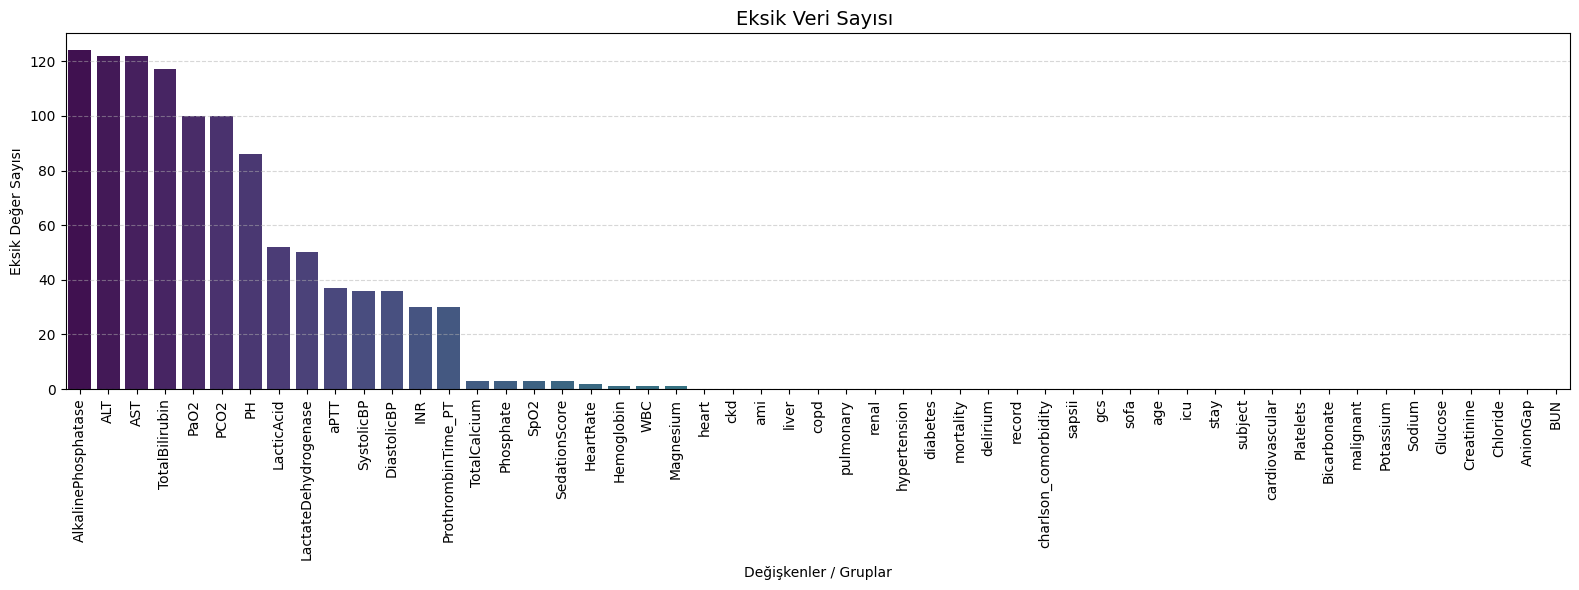

In [ ]:
missing_count = df.isnull().sum()

# Aynı isme sahip değişkenleri grupla
grouped_missing = {}

for col in missing_count.index:
    if '_' in col:
        base = col.rsplit('_', 1)[0]
    else:
        base = col
    grouped_missing.setdefault(base, []).append(col)

# Eksik değer sayılarını hesapla
final_missing = {}

for base, cols in grouped_missing.items():
    counts = missing_count[cols]
    if len(set(counts)) == 1:
        final_missing[f"{base}"] = counts.iloc[0]
    else:
        for col in cols:
            final_missing[col] = missing_count[col]

missing_df = pd.DataFrame.from_dict(final_missing, orient='index', columns=['missing_count'])
missing_df = missing_df.sort_values(by='missing_count', ascending=False)

# Görselleştirme
plt.figure(figsize=(max(8, len(missing_df) * 0.3), 6))
sns.barplot(x=missing_df.index, y=missing_df['missing_count'], palette='viridis')
plt.title('Eksik Veri Sayısı ', fontsize=14)
plt.ylabel('Eksik Değer Sayısı')
plt.xlabel('Değişkenler / Gruplar')
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Grafikte görüldüğü üzere veri setimizde iki adet hedef değişken bulunmaktadır: *mortality* (ölüm oranı) ve *delirium_positive* (deliryum pozitifliği)**

Her iki değişkenin de 0 ve 1 olmak üzere iki sınıfı vardır. Ancak dağılımlara baktığımızda, her iki değişkende de sınıflar arasında belirgin bir dengesizlik (imbalance) olduğu görülmektedir.

- Mortality değişkeninde, 0 (hayatta kalanlar) sınıfı 395 iken, 1 (vefat edenler) sınıfı yalnızca 190 örneğe sahiptir.

- Delirium_positive değişkeninde ise, 0 (deliryum görülmeyenler) sınıfı 513, 1 (deliryum görülenler) sınıfı ise sadece 72 örnektir.

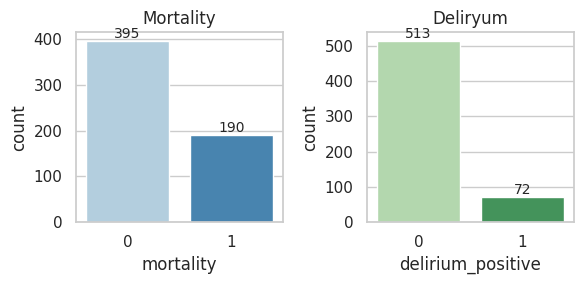

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Mortality grafiği
sns.countplot(ax=axes[0], x='mortality', hue='mortality', data=df, palette='Blues', legend=False)
axes[0].set_title('Mortality')
for p in axes[0].patches:
    count = int(p.get_height())
    axes[0].annotate(str(count), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

# Deliryum grafiği
sns.countplot(ax=axes[1], x='delirium_positive', hue='delirium_positive', data=df, palette='Greens', legend=False)
axes[1].set_title('Deliryum')
for p in axes[1].patches:
    count = int(p.get_height())
    axes[1].annotate(str(count), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

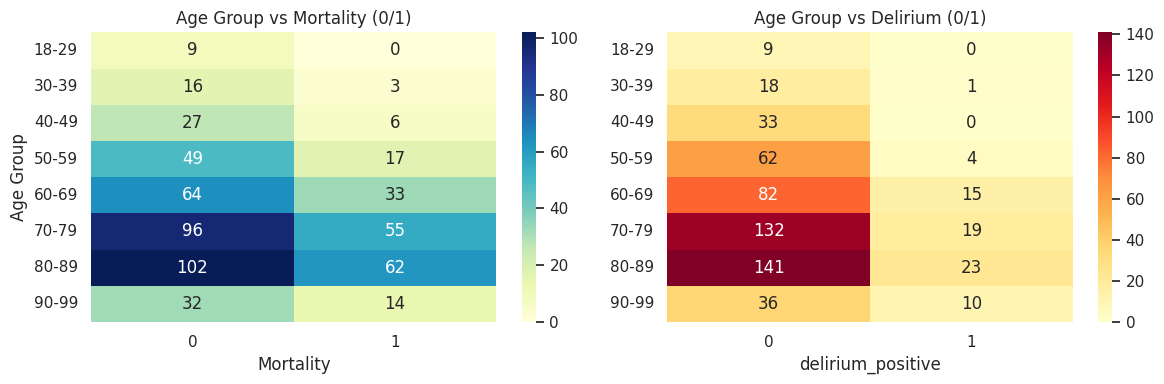

In [ ]:
# 18 yaş ve üzerindeki kişileri filtrele
df_filtered = df[df['age'] >= 18].copy()

# Yaş gruplarını tanımla
age_bins = [18, 29, 39, 49, 59, 69, 79, 89, 99, 120]
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']
df_filtered['age_group'] = pd.cut(df_filtered['age'], bins=age_bins, labels=age_labels, right=False)

# Sadece 0 ve 1 içeren tablolar
cross_tab_mortality = pd.crosstab(df_filtered['age_group'], df_filtered['mortality'])
cross_tab_delirium = pd.crosstab(df_filtered['age_group'], df_filtered['delirium_positive'])

# Sadece 0 ve 1 sütunlarını al
cross_tab_mortality = cross_tab_mortality[[0, 1]] if set([0, 1]).issubset(cross_tab_mortality.columns) else cross_tab_mortality
cross_tab_delirium = cross_tab_delirium[[0, 1]] if set([0, 1]).issubset(cross_tab_delirium.columns) else cross_tab_delirium

# Yan yana 2 heatmap çiz
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cross_tab_mortality, annot=True, cmap='YlGnBu', fmt='d', cbar=True, ax=axes[0])
axes[0].set_title('Age Group vs Mortality (0/1)')
axes[0].set_xlabel('Mortality')
axes[0].set_ylabel('Age Group')

sns.heatmap(cross_tab_delirium, annot=True, cmap='YlOrRd', fmt='d', cbar=True, ax=axes[1])
axes[1].set_title('Age Group vs Delirium (0/1)')
axes[1].set_xlabel('delirium_positive')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

**Boş Verileri Doldurma Yöntemi:**

- Sayısal değişkenler,medyan değerine göre doldurulmuştur. Bu yaklaşım, veri setindeki uç değerlerden etkilenmemesi nedeniyle tercih edilmiştir.

- Kategorik değişkenler ise, ilgili sütundaki en sık gözlemlenen değer olan mod ile doldurulmaktadır.

In [ ]:
# Sayısal sütunları medyan ile
numerical_cols = df.select_dtypes(include=['float64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Kategorik sütunları tek tek mod ile
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()
        if not mode_val.empty:
            df[col] = df[col].fillna(mode_val.iloc[0])

Eksik verilerin oranı genel olarak düşük olduğu için, her iki yöntem de model performansı üzerinde benzer etkiler göstermiştir. Ancak model tabanlı doldurma yöntemleri daha fazla zaman ve işlem gücü gerektirdiğinden, üstte yer alan klasik doldurma yöntemi tercih edilmiştir.

In [ ]:
'''missing_ratio = df.isnull().mean() * 100
missing_cols = missing_ratio[missing_ratio > 0].index'''

'missing_ratio = df.isnull().mean() * 100\nmissing_cols = missing_ratio[missing_ratio > 0].index'

In [ ]:
'''from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Eksik değeri %5 ve altı olanlar
cols_under_5 = missing_ratio[missing_ratio <= 5].index

imputer_mice = IterativeImputer(estimator=BayesianRidge(), random_state=0)

df[cols_under_5] = imputer_mice.fit_transform(df[cols_under_5])'''

'from sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\nfrom sklearn.linear_model import BayesianRidge\n\n# Eksik değeri %5 ve altı olanlar\ncols_under_5 = missing_ratio[missing_ratio <= 5].index\n\nimputer_mice = IterativeImputer(estimator=BayesianRidge(), random_state=0)\n\ndf[cols_under_5] = imputer_mice.fit_transform(df[cols_under_5])'

In [ ]:
'''cols_above_5 = missing_ratio[missing_ratio > 5].index'''

'cols_above_5 = missing_ratio[missing_ratio > 5].index'

In [ ]:
'''from sklearn.ensemble import RandomForestRegressor

high_missing = missing_ratio[missing_ratio > 5].index
features = df.columns.drop(high_missing)

for col in high_missing:
    temp_df = df.copy()

    train = temp_df[temp_df[col].notnull()]
    test = temp_df[temp_df[col].isnull()]

    if not test.empty:
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(train[features], train[col])

        predicted = model.predict(test[features])
        df.loc[df[col].isnull(), col] = predicted
'''

'from sklearn.ensemble import RandomForestRegressor\n\nhigh_missing = missing_ratio[missing_ratio > 5].index\nfeatures = df.columns.drop(high_missing)\n\nfor col in high_missing:\n    temp_df = df.copy()\n\n    train = temp_df[temp_df[col].notnull()]\n    test = temp_df[temp_df[col].isnull()]\n\n    if not test.empty:\n        model = RandomForestRegressor(n_estimators=100, random_state=42)\n        model.fit(train[features], train[col])\n\n        predicted = model.predict(test[features])\n        df.loc[df[col].isnull(), col] = predicted\n'

In [ ]:
df.head()

,subject_id,stay_id,icu_los,age,sofa_score,gcs,sapsii,charlson_comorbidity_index,record_count,delirium_positive,mortality,diabetes,hypertension,renal_failure,pulmonary,cardiovascular,liver_failure,ami,ckd,copd,heart_failure,malignant_tumor,ALT_min,ALT_median,ALT_max,ALT_avg,AlkalinePhosphatase_min,AlkalinePhosphatase_median,AlkalinePhosphatase_max,AlkalinePhosphatase_avg,Magnesium_min,Magnesium_median,Magnesium_max,Magnesium_avg,Hemoglobin_min,Hemoglobin_median,Hemoglobin_max,Hemoglobin_avg,TotalCalcium_min,TotalCalcium_median,TotalCalcium_max,TotalCalcium_avg,Phosphate_min,Phosphate_median,Phosphate_max,Phosphate_avg,Bicarbonate_min,Bicarbonate_median,Bicarbonate_max,Bicarbonate_avg,AnionGap_min,AnionGap_median,AnionGap_max,AnionGap_avg,PH_min,PH_median,PH_max,PH_avg,Chloride_min,Chloride_median,Chloride_max,Chloride_avg,Creatinine_min,Creatinine_median,Creatinine_max,Creatinine_avg,Glucose_min,Glucose_median,Glucose_max,Glucose_avg,Sodium_min,Sodium_median,Sodium_max,Sodium_avg,Potassium_min,Potassium_median,Potassium_max,Potassium_avg,Platelets_min,Platelets_median,Platelets_max,Platelets_avg,WBC_min,WBC_median,WBC_max,WBC_avg,LactateDehydrogenase_min,LactateDehydrogenase_median,LactateDehydrogenase_max,LactateDehydrogenase_avg,AST_min,AST_median,AST_max,AST_avg,TotalBilirubin_min,TotalBilirubin_median,TotalBilirubin_max,TotalBilirubin_avg,ProthrombinTime_PT_min,ProthrombinTime_PT_median,ProthrombinTime_PT_max,ProthrombinTime_PT_avg,INR_min,INR_median,INR_max,INR_avg,BUN_min,BUN_median,BUN_max,BUN_avg,aPTT_min,aPTT_median,aPTT_max,aPTT_avg,PaO2_min,PaO2_median,PaO2_max,PaO2_avg,PCO2_min,PCO2_median,PCO2_max,PCO2_avg,LacticAcid_min,LacticAcid_median,LacticAcid_max,LacticAcid_avg,HeartRate_min,HeartRate_median,HeartRate_max,HeartRate_avg,SystolicBP_min,SystolicBP_median,SystolicBP_max,SystolicBP_avg,DiastolicBP_min,DiastolicBP_median,DiastolicBP_max,DiastolicBP_avg,SedationScore_min,SedationScore_median,SedationScore_max,SedationScore_avg,SpO2_min,SpO2_median,SpO2_max,SpO2_avg
0,10017851,39558308,1.25,75,4,15.00,60,6,1,0,1,0,0,1,0,1,0,0,0,1,1,0,41.00,44.50,47.00,44.50,91.00,95.00,101.00,94.50,1.50,1.50,1.50,1.50,10.60,10.60,10.60,10.60,7.30,7.30,7.30,7.30,4.60,4.60,4.60,4.60,22.00,22.00,22.00,22.00,18.00,18.00,18.00,18.00,7.14,7.25,7.26,7.22,105.00,105.00,105.00,105.00,1.70,1.70,1.70,1.70,127.00,127.00,127.00,127.00,140.00,140.00,140.00,140.00,4.50,4.50,4.50,4.50,492.00,492.00,492.00,492.00,20.40,20.40,20.40,20.40,3.40,4.10,4.60,4.03,61.00,69.00,72.00,68.33,1.00,1.08,1.20,1.10,50.40,50.40,50.40,50.40,5.50,5.50,5.50,5.50,52.00,52.00,52.00,52.00,42.70,42.70,42.70,42.70,18.00,45.00,181.00,81.33,51.00,54.00,72.00,59.00,3.40,4.10,4.60,4.03,105.00,126.00,148.00,126.58,80.00,101.00,135.00,100.15,38.00,56.00,85.00,58.39,8.00,24.00,35.00,22.82,76.00,96.00,100.00,93.70
1,10020944,30757476,9.08,72,5,14.95,50,10,1,1,0,0,0,1,0,1,0,0,1,1,0,1,15.00,23.50,32.00,23.50,105.00,109.00,113.00,109.00,1.30,1.60,1.80,1.57,10.00,10.60,11.20,10.60,7.60,8.20,8.30,8.03,1.20,1.50,4.80,2.50,24.00,25.00,27.00,25.33,8.00,8.50,9.00,8.50,7.13,7.28,7.44,7.28,103.00,110.00,111.00,108.00,1.20,1.20,1.40,1.27,34.00,64.00,124.00,74.00,132.00,140.00,141.00,137.67,4.30,4.55,4.80,4.55,151.00,158.50,166.00,158.50,9.30,11.00,12.70,11.00,1.10,2.10,3.10,2.10,21.00,69.50,118.00,69.50,0.40,0.40,0.40,0.40,12.60,13.05,13.50,13.05,1.20,1.20,1.20,1.20,31.00,31.00,34.00,32.00,32.60,33.30,34.00,33.30,30.00,80.00,101.00,76.00,38.00,53.00,84.00,56.00,1.10,2.10,3.10,2.10,53.00,56.00,78.00,58.31,101.00,113.00,113.00,109.00,59.00,62.00,69.00,63.33,6.00,16.00,28.00,17.32,93.00,97.00,100.00,96.83
2,10032381,34622731,42.65,64,3,14.85,47,4,1,0,0,0,0,1,0,1,0,0,0,0,1,0,9.00,9.00,9.00,9.00,65.00,65.50,66.00,65.50,1.20,1.85,2.50,1.85,8.10,8.70,9.30,8.70,7.10,7.70,8.30,7.70,3.50,3.90,4.30,3.90,23.00,24.50,26.00,24.50,13.00,13.50,14.00,13.50,7.36,7.42,7.47,7.42,104.00,104.50,105.00,104.50,1.20,1.25,1.30,1.25,110.00,113.00,116.00,113.00,138.00,138.50,139.00,138.50,3.20,3.85,4.50,3.85,363.00,397.

In [ ]:
df.isnull().values.any()

np.False_

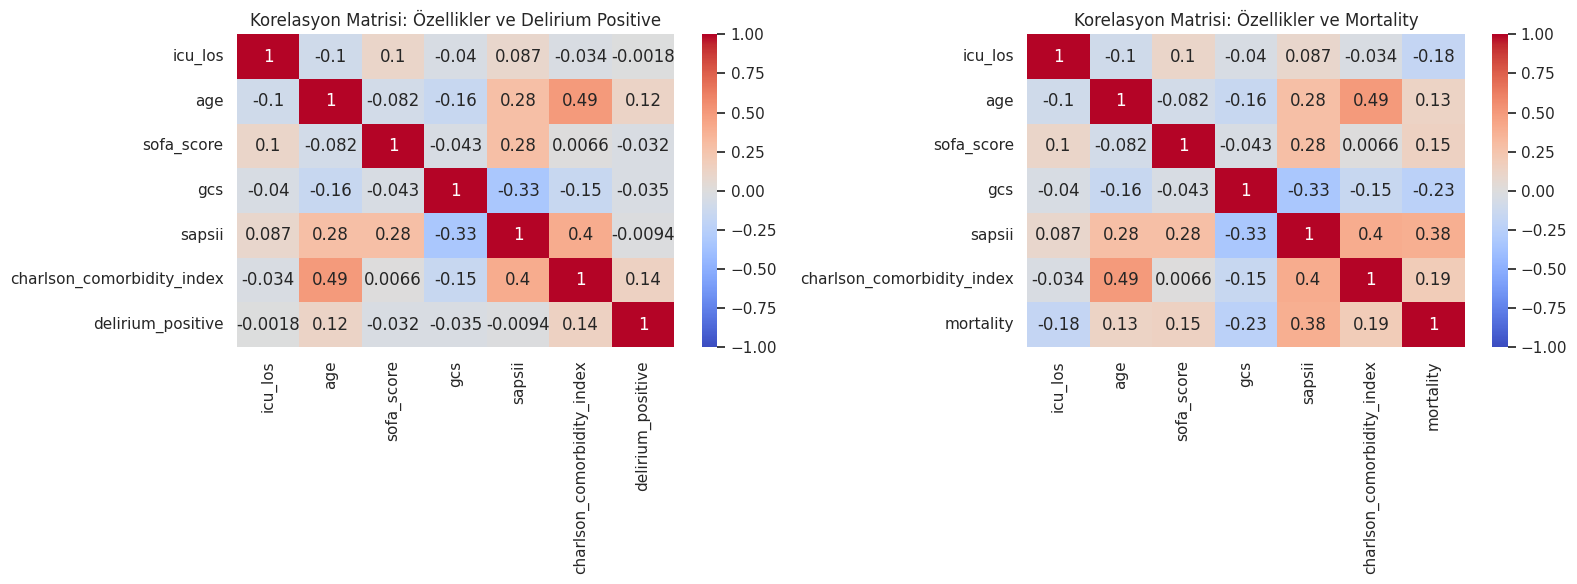

In [ ]:
features = ['icu_los', 'age', 'sofa_score', 'gcs', 'sapsii', 'charlson_comorbidity_index']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Delirium ile korelasyon
corr_delirium = df[features + ['delirium_positive']].corr()
sns.heatmap(corr_delirium, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Korelasyon Matrisi: Özellikler ve Delirium Positive')

# Mortality ile korelasyon
corr_mortality = df[features + ['mortality']].corr()
sns.heatmap(corr_mortality, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Korelasyon Matrisi: Özellikler ve Mortality')

plt.tight_layout()
plt.show()


 **pulmonary:** Bu değişken tüm kişilerde 0 gelmektedir. Bu nedenle modelde veri setinden çıkarılmıştır.

In [ ]:
df = df.drop(columns=['pulmonary'])

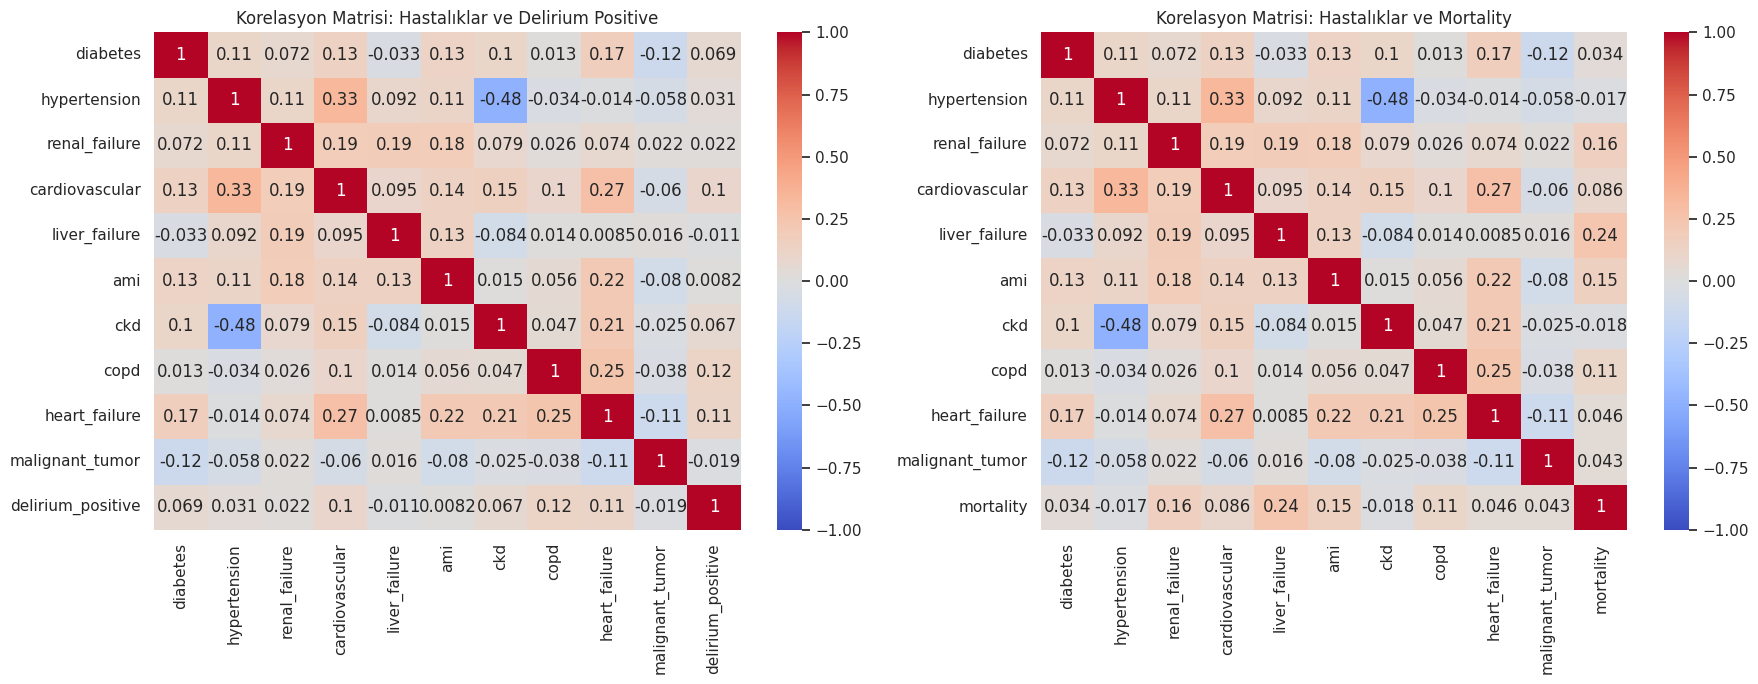

In [ ]:
features = [
    'diabetes', 'hypertension', 'renal_failure', 'cardiovascular',
    'liver_failure', 'ami', 'ckd', 'copd', 'heart_failure', 'malignant_tumor'
]

targets = ['delirium_positive', 'mortality']

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Delirium için korelasyon
corr_delirium = df[features + ['delirium_positive']].corr()
sns.heatmap(corr_delirium, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Korelasyon Matrisi: Hastalıklar ve Delirium Positive')

# Mortality için korelasyon
corr_mortality = df[features + ['mortality']].corr()
sns.heatmap(corr_mortality, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Korelasyon Matrisi: Hastalıklar ve Mortality')

plt.tight_layout()
plt.show()

## İSTATİKSEL TEST ANALİZİ

**1. Değişken Türlerinin Tespiti**

Verideki sütunları türlerine göre sayısal ve kategorik olarak ayırır.
Ayrıca, sadece iki farklı değere sahip olan sayısal sütunları da kategorik olarak değerlendirir.

In [ ]:
# --- 1. Sayısal ve Kategorik Değişkenleri Tespit Eden Fonsiyon ---
def detect_variable_types(df):
    categorical_columns = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # bool tipi zaten categorical'a eklendigi icin, numeric'ten çıkarıldı
    numeric_columns = [col for col in numeric_columns if col not in categorical_columns]

    # Sayısal görünen ama aslında binary kategorik olan sütunlar ayrilir
    binary_categoricals = [col for col in numeric_columns if df[col].nunique() == 2]
    categorical_columns += binary_categoricals
    numeric_columns = [col for col in numeric_columns if col not in binary_categoricals]

    return categorical_columns, numeric_columns

**2. Kategorik Değişken Analizi**

Kategorik değişkenlerle hedef değişken arasındaki ilişkiyi incelemek için kullanılır.
2x2 tablo oluşan durumlarda Fisher's Exact Test uygulanır çünkü küçük örneklem ve sınıf sayılarında güvenilirdir.
Test sonuçları p-değeri olarak raporlanır.

In [ ]:
# --- 2. Kategorik Değişken Analizi
def test_categorical_variables(df, target_col, cat_cols):
    results = []
    for col in cat_cols:
        if col == target_col:
            continue
        if df[col].nunique() > 20:
            print(f"{col} değişkeninde çok fazla sınıf var. Sonuçlar güvenilir olmayabilir.")
            continue

        table = pd.crosstab(df[target_col], df[col])

        if table.shape == (2, 2):
            try:
                _, p_val = stats.fisher_exact(table)
            except:
                p_val = 1.0  # hesaplanamazsa
            results.append({
                'Değişken': col,
                'Test': 'Fisher',
                'p-değeri': round(p_val, 4)
            })
        else:
            print(f"{col} değişkeni 2x2 tablo oluşturmuyor. Atlandı.")

    return pd.DataFrame(results)


**3. Sayısal Değişken Analizi**

Sayısal değişkenlerin hedef değişkene göre gruplar arasında farklılık gösterip göstermediği test edilir.
Önce grupların normal dağılıma uyup uymadığı Shapiro-Wilk testi ile kontrol edilir.
Dağılım normalse t-testi, değilse Mann-Whitney U testi uygulanır.

In [ ]:
# --- 3. Sayısal Değişken Analizi ---
def test_numeric_variables(df, target_col, numeric_cols):
    results = []
    for col in numeric_cols:
        group1 = df[df[target_col] == 1][col].dropna()
        group2 = df[df[target_col] == 0][col].dropna()

        if len(group1) < 3 or len(group2) < 3:
            continue  # Anlamsız örneklem boyutu

        # Normal dağılım testi
        _, p_shapiro1 = stats.shapiro(group1) if len(group1) <= 5000 else (None, 1)
        _, p_shapiro2 = stats.shapiro(group2) if len(group2) <= 5000 else (None, 1)

        normal1 = p_shapiro1 > 0.05
        normal2 = p_shapiro2 > 0.05

        # Uygun test
        if normal1 and normal2:
            test = 't-test'
            _, p_val = stats.ttest_ind(group1, group2)
        else:
            test = 'Mann-Whitney U'
            _, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')

        results.append({
            'Değişken': col,
            'Test': test,
            'p-değeri': round(p_val, 4),
            'Normal Dağılım (Grup 1)': normal1,
            'Normal Dağılım (Grup 2)': normal2
        })
    return pd.DataFrame(results)

**Deliryum Pozitifliği İçin Değişken Analizi**

Verideki değişkenler delirium_positive hedef değişkenine göre analiz edilmiştir.
Öncelikle değişken türleri (kategorik ve sayısal) belirlenmiş, ardından her grup için uygun istatistiksel testler uygulanmıştır

In [ ]:
target_col = 'delirium_positive'

# Değişken türlerini tespiti
categorical_columns_del, numeric_columns_del = detect_variable_types(df)

# Kategorik analiz
cat_result_del = test_categorical_variables(df, target_col, categorical_columns_del)

# Sayısal analiz
num_result_del = test_numeric_variables(df, target_col, numeric_columns_del)

print("Kategorik Değişkenler İçin Test Sonuçları")
print(cat_result_del.sort_values('p-değeri'))

print("\nSayısal Değişkenler İçin Test Sonuçları")
print(num_result_del.sort_values('p-değeri'))

Kategorik Değişkenler İçin Test Sonuçları
           Değişken    Test  p-değeri
8              copd  Fisher      0.01
9     heart_failure  Fisher      0.01
4    cardiovascular  Fisher      0.01
1          diabetes  Fisher      0.11
7               ckd  Fisher      0.11
2      hypertension  Fisher      0.45
3     renal_failure  Fisher      0.69
10  malignant_tumor  Fisher      0.75
6               ami  Fisher      0.85
0         mortality  Fisher      1.00
5     liver_failure  Fisher      1.00

Sayısal Değişkenler İçin Test Sonuçları
                        Değişken            Test  p-değeri  Normal Dağılım (Grup 1)  Normal Dağılım (Grup 2)
25              TotalCalcium_min  Mann-Whitney U      0.00                     True                    False
28              TotalCalcium_avg  Mann-Whitney U      0.00                     True                    False
26           TotalCalcium_median  Mann-Whitney U      0.00                     True                    False
7     charlson_comorbidit

**Deliryum İçin Anlamlı Değişkenlerin Belirlenmesi**

Yapılan testler sonucunda p-değeri 0.05’ten küçük olan değişkenler istatistiksel olarak anlamlı kabul edilmiştir.
Bu kısımda hem kategorik hem de sayısal anlamlı değişkenler listelenerek deliryum ile ilişkili olabilecek faktörler belirlenmiştir.

- p < 0.05 → Değişken ile hedef arasında anlamlı istatistiksel ilişki vardır.

- p >= 0.05 → Anlamlı ilişki yoktur (rastgele olabilir).

In [ ]:
onemli_cat_del = cat_result_del[cat_result_del['p-değeri'] < 0.05]
onemli_num_del = num_result_del[num_result_del['p-değeri'] < 0.05]

print("\nAnlamlı Kategorik Değişkenler:")
print(onemli_cat_del)

print("\nAnlamlı Sayısal Değişkenler:")
print(onemli_num_del)


Anlamlı Kategorik Değişkenler:
         Değişken    Test  p-değeri
4  cardiovascular  Fisher      0.01
8            copd  Fisher      0.01
9   heart_failure  Fisher      0.01

Anlamlı Sayısal Değişkenler:
                      Değişken            Test  p-değeri  Normal Dağılım (Grup 1)  Normal Dağılım (Grup 2)
3                          age  Mann-Whitney U      0.01                    False                    False
7   charlson_comorbidity_index  Mann-Whitney U      0.00                     True                    False
25            TotalCalcium_min  Mann-Whitney U      0.00                     True                    False
26         TotalCalcium_median  Mann-Whitney U      0.00                     True                    False
27            TotalCalcium_max  Mann-Whitney U      0.00                    False                    False
28            TotalCalcium_avg  Mann-Whitney U      0.00                     True                    False
41                      PH_min  Mann-Whitney 

**Mortalite İçin Değişken Analizi**

Verideki değişkenler mortality hedef değişkenine göre analiz edilmiştir.
Öncelikle değişken türleri (kategorik ve sayısal) belirlenmiş, ardından her grup için uygun istatistiksel testler uygulanmıştır

In [ ]:
target_col_2 = 'mortality'

# Değişken türleri tespiti
categorical_columns_mort, numeric_columns_mort = detect_variable_types(df)

# İstatistiksel analizler
cat_results_mort = test_categorical_variables(df, target_col_2, categorical_columns_mort)
num_results_mort = test_numeric_variables(df, target_col_2, numeric_columns_mort)

print("Kategorik Değişkenler İçin Test Sonuçları")
print(cat_results_mort)
print("\nSayısal Değişkenler İçin Test Sonuçları")
print(num_results_mort)




Kategorik Değişkenler İçin Test Sonuçları
             Değişken    Test  p-değeri
0   delirium_positive  Fisher      1.00
1            diabetes  Fisher      0.45
2        hypertension  Fisher      0.72
3       renal_failure  Fisher      0.00
4      cardiovascular  Fisher      0.04
5       liver_failure  Fisher      0.00
6                 ami  Fisher      0.00
7                 ckd  Fisher      0.68
8                copd  Fisher      0.01
9       heart_failure  Fisher      0.26
10    malignant_tumor  Fisher      0.31

Sayısal Değişkenler İçin Test Sonuçları
                        Değişken            Test  p-değeri  Normal Dağılım (Grup 1)  Normal Dağılım (Grup 2)
0                     subject_id  Mann-Whitney U      0.14                    False                    False
1                        stay_id  Mann-Whitney U      0.86                    False                    False
2                        icu_los  Mann-Whitney U      0.04                    False                    False
3

**Mortalite İçin Anlamlı Değişkenlerin Belirlenmesi**

Yapılan testler sonucunda p-değeri 0.05’ten küçük olan değişkenler istatistiksel olarak anlamlı kabul edilmiştir.
Bu kısımda hem kategorik hem de sayısal anlamlı değişkenler listelenerek deliryum ile ilişkili olabilecek faktörler belirlenmiştir.

- p < 0.05 → Değişken ile hedef arasında anlamlı istatistiksel ilişki vardır.

- p >= 0.05 → Anlamlı ilişki yoktur (rastgele olabilir).

In [ ]:
onemli_cat_mort = cat_results_mort[cat_results_mort['p-değeri'] < 0.05]
onemli_num_mort = num_results_mort[num_results_mort['p-değeri'] < 0.05]


print("\nAnlamlı Kategorik Değişkenler:")
print(onemli_cat_mort)

print("\nAnlamlı Sayısal Değişkenler:")
print(onemli_num_mort)



Anlamlı Kategorik Değişkenler:
         Değişken    Test  p-değeri
3   renal_failure  Fisher      0.00
4  cardiovascular  Fisher      0.04
5   liver_failure  Fisher      0.00
6             ami  Fisher      0.00
8            copd  Fisher      0.01

Anlamlı Sayısal Değişkenler:
                        Değişken            Test  p-değeri  Normal Dağılım (Grup 1)  Normal Dağılım (Grup 2)
2                        icu_los  Mann-Whitney U      0.04                    False                    False
3                            age  Mann-Whitney U      0.01                    False                    False
4                     sofa_score  Mann-Whitney U      0.01                    False                    False
5                            gcs  Mann-Whitney U      0.00                    False                    False
6                         sapsii  Mann-Whitney U      0.00                    False                    False
7     charlson_comorbidity_index  Mann-Whitney U      0.00          

**Deliryum ve Mortalite İçin Anlamsız Kategorik Değişkenlerin Belirlenmesi**

Deliryum (delirium_positive) ve mortality hedef değerleri için p-değeri 0.05 ve üzeri olan (yani istatistiksel olarak anlamlı olmayan) kategorik değişkenler seçilir. Sonrasında her iki hedef için anlamsız çıkan ortak kategorik değişkenleri listelenmektedir.

In [ ]:
anlamsiz_cat_del = cat_result_del[cat_result_del['p-değeri'] >= 0.05][['Değişken', 'p-değeri']]
anlamsiz_cat_mort = cat_results_mort[cat_results_mort['p-değeri'] >= 0.05][['Değişken', 'p-değeri']]
anlamsiz_cat_both = pd.merge(anlamsiz_cat_del, anlamsiz_cat_mort, on='Değişken', suffixes=('_del', '_mort'))

print("Her iki hedef için de anlamsız kategorik değişkenler:\n")
print(anlamsiz_cat_both)


Her iki hedef için de anlamsız kategorik değişkenler:

          Değişken  p-değeri_del  p-değeri_mort
0         diabetes          0.11           0.45
1     hypertension          0.45           0.72
2              ckd          0.11           0.68
3  malignant_tumor          0.75           0.31


**Deliryum ve Mortalite İçin Anlamsız Sayısal Değişkenlerin Belirlenmesi**

Deliryum (delirium_positive) ve mortality hedef değerleri için p-değeri 0.05 ve üzeri olan (yani istatistiksel olarak anlamlı olmayan) sayısal değişkenler seçilir. Sonrasında her iki hedef için anlamsız çıkan ortak sayısal değişkenleri listelenmektedir.

In [ ]:
anlamsiz_num_del = num_result_del[num_result_del['p-değeri'] >= 0.05][['Değişken', 'p-değeri']]
anlamsiz_num_mort = num_results_mort[num_results_mort['p-değeri'] >= 0.05][['Değişken', 'p-değeri']]

ortak_anlamsiz_num = pd.merge(anlamsiz_num_del, anlamsiz_num_mort, on='Değişken', suffixes=('_del', '_mort'))

print("Her iki hedef için de anlamsız sayısal değişkenler:\n")
print(ortak_anlamsiz_num)


Her iki hedef için de anlamsız sayısal değişkenler:

                      Değişken  p-değeri_del  p-değeri_mort
0                   subject_id          0.90           0.14
1                      stay_id          0.43           0.86
2                      ALT_min          0.57           0.25
3                   ALT_median          0.45           0.10
4                      ALT_max          0.42           0.14
5                      ALT_avg          0.44           0.11
6      AlkalinePhosphatase_min          0.58           0.11
7   AlkalinePhosphatase_median          0.59           0.12
8      AlkalinePhosphatase_max          0.73           0.14
9      AlkalinePhosphatase_avg          0.64           0.12
10              Hemoglobin_min          0.95           0.49
11           Hemoglobin_median          0.85           0.95
12              Hemoglobin_max          0.58           0.46
13              Hemoglobin_avg          0.80           0.88
14             Bicarbonate_max          0.74   

## MODEL

**Train(%80)-Test(%20), Sadece Modelle Eğitilmiş Hali**

Modelleme sürecinde hem ölüm (mortality) hem de deliryum (delirium_positive) için ayrı ayrı XGBoost modelleri eğitilmiştir. Eğitim (%80) ve test (%20) ayrımı yapılırken, her iki hedefin sınıf dengesini korumak için **y_stratify = y_mortality.astype(str) + "_" + y_delirium.astype(str) i**fadesi stratify parametresi olarak kullanılmıştır.

In [ ]:
ID = df['subject_id'].values
X = df.drop(columns=['mortality', 'delirium_positive', 'subject_id']).values
y_mortality = df['mortality'].values
y_delirium = df['delirium_positive'].values

y_stratify = (y_mortality.astype(str) + "_" + y_delirium.astype(str))

X_train, X_test, y_train_mortality, y_test_mortality, y_train_delirium, y_test_delirium, ID_train, ID_test = train_test_split(
    X, y_mortality, y_delirium, ID,
    test_size=0.2, random_state=42, stratify=y_stratify
)


model_xgb_mortality = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb_delirium = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

model_xgb_mortality.fit(X_train, y_train_mortality)
model_xgb_delirium.fit(X_train, y_train_delirium)

# Değerlendirme
def evaluate(model, X, y, label=""):
    prob = model.predict_proba(X)[:, 1]
    pred = model.predict(X)
    auc_score = roc_auc_score(y, prob)
    acc = accuracy_score(y, pred)
    precision = precision_score(y, pred)
    recall = recall_score(y, pred)
    f1 = f1_score(y, pred)
    conf_matrix = confusion_matrix(y, pred)

    print(f"\n=== {label} ===")
    print(f"ROC AUC: {auc_score:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y, pred))

evaluate(model_xgb_mortality, X_test, y_test_mortality, "XGBoost - Mortality")
evaluate(model_xgb_delirium, X_test, y_test_delirium, "XGBoost - Delirium")



=== XGBoost - Mortality ===
ROC AUC: 0.8158
Confusion Matrix:
[[73  6]
 [23 15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83        79
           1       0.71      0.39      0.51        38

    accuracy                           0.75       117
   macro avg       0.74      0.66      0.67       117
weighted avg       0.75      0.75      0.73       117


=== XGBoost - Delirium ===
ROC AUC: 0.5033
Confusion Matrix:
[[99  3]
 [15  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       102
           1       0.00      0.00      0.00        15

    accuracy                           0.85       117
   macro avg       0.43      0.49      0.46       117
weighted avg       0.76      0.85      0.80       117



**Validation(%15)-Test(%15)-Train(%70) Olarak Ayrılmış, Sadece Modelle Eğitilmiş Hali**

Veri, her iki hedefin sınıf dağılımını koruyacak şekilde birleşik bir stratify etiketi kullanılarak %70 eğitim, %15 doğrulama ve %15 test olarak bölündü. Her hedef için ayrı XGBoost sınıflandırıcıları varsayılan ayarlarla eğitildi ve ROC AUC, confusion matrix gibi temel metriklerle değerlendirildi.



In [ ]:
ID = df['subject_id'].values
X = df.drop(columns=['mortality', 'delirium_positive', 'subject_id']).values
y_mortality = df['mortality'].values
y_delirium = df['delirium_positive'].values

y_stratify = y_mortality.astype(str) + "_" + y_delirium.astype(str)

# 1. Split: train_temp (70%) ve test (30%)
X_train_temp, X_test, y_train_temp_mortality, y_test_mortality, y_train_temp_delirium, y_test_delirium, ID_train_temp, ID_test = train_test_split(
    X, y_mortality, y_delirium, ID,
    test_size=0.30,
    random_state=42,
    stratify=y_stratify
)

y_train_temp_stratify = y_train_temp_mortality.astype(str) + "_" + y_train_temp_delirium.astype(str)

# 2. Split: train (70%) ve val (30%) (temp setten)
X_train, X_val, y_train_mortality, y_val_mortality, y_train_delirium, y_val_delirium, ID_train, ID_val = train_test_split(
    X_train_temp, y_train_temp_mortality, y_train_temp_delirium, ID_train_temp,
    test_size=0.2143,
    random_state=42,
    stratify=y_train_temp_stratify
)

# Model
model_xgb_mortality = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb_delirium = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Eğitim
model_xgb_mortality.fit(X_train, y_train_mortality)
model_xgb_delirium.fit(X_train, y_train_delirium)

# Değerlendirme
def evaluate(model, X, y, label=""):
    prob = model.predict_proba(X)[:, 1]
    pred = model.predict(X)
    print(f"\n=== {label} ===")
    print(f"ROC AUC: {roc_auc_score(y, prob):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, pred))
    print("\nClassification Report:")
    print(classification_report(y, pred))

evaluate(model_xgb_mortality, X_val, y_val_mortality, "Validation - Mortality")
evaluate(model_xgb_delirium, X_val, y_val_delirium, "Validation - Delirium")

evaluate(model_xgb_mortality, X_test, y_test_mortality, "Test - Mortality")
evaluate(model_xgb_delirium, X_test, y_test_delirium, "Test - Delirium")



=== Validation - Mortality ===
ROC AUC: 0.7598
Confusion Matrix:
[[49 10]
 [13 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        59
           1       0.62      0.55      0.58        29

    accuracy                           0.74        88
   macro avg       0.70      0.69      0.70        88
weighted avg       0.73      0.74      0.73        88


=== Validation - Delirium ===
ROC AUC: 0.5431
Confusion Matrix:
[[76  1]
 [11  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        77
           1       0.00      0.00      0.00        11

    accuracy                           0.86        88
   macro avg       0.44      0.49      0.46        88
weighted avg       0.76      0.86      0.81        88


=== Test - Mortality ===
ROC AUC: 0.7758
Confusion Matrix:
[[107  12]
 [ 31  26]]

Classification Report:
              precisio

**Validation(%20)-Test(%20)-Train(%60) Olarak Ayrılmış, Sadece Modelle Eğitilmiş Hali**

Veri, her iki hedefin sınıf dağılımını koruyacak şekilde birleşik bir stratify etiketi kullanılarak %60 eğitim, %20 doğrulama ve %20 test olarak bölündü. Her hedef için ayrı XGBoost sınıflandırıcıları varsayılan ayarlarla eğitildi ve ROC AUC, confusion matrix gibi temel metriklerle değerlendirildi.

In [ ]:
ID = df['subject_id'].values
X = df.drop(columns=['mortality', 'delirium_positive', 'subject_id']).values
y_mortality = df['mortality'].values
y_delirium = df['delirium_positive'].values

y_stratify = y_mortality.astype(str) + "_" + y_delirium.astype(str)

# 1. Split: train (60%) ve temp (40%)
X_train, X_temp, y_train_mortality, y_temp_mortality, y_train_delirium, y_temp_delirium, ID_train, ID_temp = train_test_split(
    X, y_mortality, y_delirium, ID,
    test_size=0.40,
    random_state=42,
    stratify=y_stratify
)

y_temp_stratify = y_temp_mortality.astype(str) + "_" + y_temp_delirium.astype(str)

# 2. Split: val (50% of temp = 20% total) ve test (50% of temp = 20% total)
X_val, X_test, y_val_mortality, y_test_mortality, y_val_delirium, y_test_delirium, ID_val, ID_test = train_test_split(
    X_temp, y_temp_mortality, y_temp_delirium, ID_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp_stratify
)


# Model
model_xgb_mortality = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb_delirium = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

model_xgb_mortality.fit(X_train, y_train_mortality)
model_xgb_delirium.fit(X_train, y_train_delirium)

# Değerlendirme
def evaluate(model, X, y, label=""):
    prob = model.predict_proba(X)[:, 1]
    pred = model.predict(X)
    print(f"\n=== {label} ===")
    print(f"ROC AUC: {roc_auc_score(y, prob):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y, pred))
    print("\nClassification Report:")
    print(classification_report(y, pred))

evaluate(model_xgb_mortality, X_val, y_val_mortality, "Validation - Mortality")
evaluate(model_xgb_delirium, X_val, y_val_delirium, "Validation - Delirium")

evaluate(model_xgb_mortality, X_test, y_test_mortality, "Test - Mortality")
evaluate(model_xgb_delirium, X_test, y_test_delirium, "Test - Delirium")



=== Validation - Mortality ===
ROC AUC: 0.8005
Confusion Matrix:
[[73  6]
 [24 14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        79
           1       0.70      0.37      0.48        38

    accuracy                           0.74       117
   macro avg       0.73      0.65      0.66       117
weighted avg       0.74      0.74      0.72       117


=== Validation - Delirium ===
ROC AUC: 0.5052
Confusion Matrix:
[[100   2]
 [ 15   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       102
           1       0.00      0.00      0.00        15

    accuracy                           0.85       117
   macro avg       0.43      0.49      0.46       117
weighted avg       0.76      0.85      0.80       117


=== Test - Mortality ===
ROC AUC: 0.8095
Confusion Matrix:
[[75  4]
 [21 17]]

Classification Report:
              precisio

**Veri Dengesizliği - BorderlineSmote**

- Veriyi önce %80 eğitim, %20 test olarak ayırıldı. Her iki hedef değişkenin (mortality ve delirium) dağılımını korumak için stratify olarak birleşik etiket kullanıldı.
- Eğitim verisi üzerinde BorderlineSMOTE ile dengesiz sınıflar dengelendi.
- Sonra XGBoost modelleri ile mortality ve delirium için ayrı ayrı eğitim yapıldı.
- BorderlineSMOTE özellikle kullanıldı çünkü veri setimiz küçük ve dengesizdi.
- Bu yöntem, azınlık sınıfa yakın sınırdaki örnekleri artırarak modelin daha iyi öğrenmesini sağlıyor.


In [ ]:
ID = df['subject_id'].values
X = df.drop(columns=['mortality', 'delirium_positive', 'subject_id']).values
y_mortality = df['mortality'].values
y_delirium = df['delirium_positive'].values

stratify_labels = [f"{m}_{d}" for m, d in zip(y_mortality, y_delirium)]

X_train, X_test, y_train_mortality, y_test_mortality, y_train_delirium, y_test_delirium, ID_train, ID_test = train_test_split(
    X, y_mortality, y_delirium, ID,
    test_size=0.2, random_state=42, stratify=stratify_labels
)

# Mortality
smote_mort = BorderlineSMOTE(random_state=42)
X_train_mortality, y_train_mortality_bal = smote_mort.fit_resample(X_train, y_train_mortality)

# Delirium
smote_delir = BorderlineSMOTE(random_state=42)
X_train_delirium, y_train_delirium_bal = smote_delir.fit_resample(X_train, y_train_delirium)

# --- Model ---
model_mortality = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
model_delirium = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

model_mortality.fit(X_train_mortality, y_train_mortality_bal)
model_delirium.fit(X_train_delirium, y_train_delirium_bal)

test_pred_prob_mortality = model_mortality.predict_proba(X_test)[:, 1]
test_pred_class_mortality = model_mortality.predict(X_test)

test_pred_prob_delirium = model_delirium.predict_proba(X_test)[:, 1]
test_pred_class_delirium = model_delirium.predict(X_test)

test_auc_mortality = roc_auc_score(y_test_mortality, test_pred_prob_mortality)
test_acc_mortality = accuracy_score(y_test_mortality, test_pred_class_mortality)

test_auc_delirium = roc_auc_score(y_test_delirium, test_pred_prob_delirium)
test_acc_delirium = accuracy_score(y_test_delirium, test_pred_class_delirium)

report_mortality = classification_report(y_test_mortality, test_pred_class_mortality)
report_delirium = classification_report(y_test_delirium, test_pred_class_delirium)

print("\n=== TEST SETİ SONUÇLARI (Mortality - XGBoost) ===")
print(f"ROC AUC: {test_auc_mortality:.4f}")
print(f"Accuracy: {test_acc_mortality:.4f}")
print("\nSınıflandırma Raporu:\n", report_mortality)

print("\n=== TEST SETİ SONUÇLARI (Delirium - XGBoost) ===")
print(f"ROC AUC: {test_auc_delirium:.4f}")
print(f"Accuracy: {test_acc_delirium:.4f}")
print("\nSınıflandırma Raporu:\n", report_delirium)


=== TEST SETİ SONUÇLARI (Mortality - XGBoost) ===
ROC AUC: 0.7831
Accuracy: 0.7778

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85        79
           1       0.71      0.53      0.61        38

    accuracy                           0.78       117
   macro avg       0.76      0.71      0.73       117
weighted avg       0.77      0.78      0.77       117


=== TEST SETİ SONUÇLARI (Delirium - XGBoost) ===
ROC AUC: 0.5810
Accuracy: 0.8462

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       102
           1       0.20      0.07      0.10        15

    accuracy                           0.85       117
   macro avg       0.54      0.51      0.51       117
weighted avg       0.79      0.85      0.81       117



**Veri Dengesizliği - Smote**

- Bu kodda SMOTE kullanıldı, yani azınlık sınıfı sentetik örneklerle arttırıldı.
- Ancak sonuçlar BorderlineSMOTE kullandığımız koda göre biraz daha düşük çıktı.

In [ ]:
ID = df['subject_id'].values
X = df.drop(columns=['mortality', 'delirium_positive', 'subject_id']).values
y_mortality = df['mortality'].values
y_delirium = df['delirium_positive'].values

stratify_labels = [f"{m}_{d}" for m, d in zip(y_mortality, y_delirium)]

X_train, X_test, y_train_mortality, y_test_mortality, y_train_delirium, y_test_delirium, ID_train, ID_test = train_test_split(
    X, y_mortality, y_delirium, ID,
    test_size=0.2, random_state=42, stratify=stratify_labels
)

# --- SMOTE ---
smote_mort = SMOTE(sampling_strategy='auto', random_state=42)
X_train_mortality, y_train_mortality_bal = smote_mort.fit_resample(X_train, y_train_mortality)

smote_delir = SMOTE(sampling_strategy='auto', random_state=42)
X_train_delirium, y_train_delirium_bal = smote_delir.fit_resample(X_train, y_train_delirium)

model_mortality = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
model_delirium = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

model_mortality.fit(X_train_mortality, y_train_mortality_bal)
model_delirium.fit(X_train_delirium, y_train_delirium_bal)

test_pred_prob_mortality = model_mortality.predict_proba(X_test)[:, 1]
test_pred_class_mortality = model_mortality.predict(X_test)

test_pred_prob_delirium = model_delirium.predict_proba(X_test)[:, 1]
test_pred_class_delirium = model_delirium.predict(X_test)

test_auc_mortality = roc_auc_score(y_test_mortality, test_pred_prob_mortality)
test_acc_mortality = accuracy_score(y_test_mortality, test_pred_class_mortality)

test_auc_delirium = roc_auc_score(y_test_delirium, test_pred_prob_delirium)
test_acc_delirium = accuracy_score(y_test_delirium, test_pred_class_delirium)

report_mortality = classification_report(y_test_mortality, test_pred_class_mortality)
report_delirium = classification_report(y_test_delirium, test_pred_class_delirium)

print("\n=== TEST SETİ SONUÇLARI (Mortality - XGBoost) ===")
print(f"ROC AUC: {test_auc_mortality:.4f}")
print(f"Accuracy: {test_acc_mortality:.4f}")
print("\nSınıflandırma Raporu:\n", report_mortality)

print("\n=== TEST SETİ SONUÇLARI (Delirium - XGBoost) ===")
print(f"ROC AUC: {test_auc_delirium:.4f}")
print(f"Accuracy: {test_acc_delirium:.4f}")
print("\nSınıflandırma Raporu:\n", report_delirium)


=== TEST SETİ SONUÇLARI (Mortality - XGBoost) ===
ROC AUC: 0.7915
Accuracy: 0.7094

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80        79
           1       0.57      0.45      0.50        38

    accuracy                           0.71       117
   macro avg       0.66      0.64      0.65       117
weighted avg       0.70      0.71      0.70       117


=== TEST SETİ SONUÇLARI (Delirium - XGBoost) ===
ROC AUC: 0.6065
Accuracy: 0.8462

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       102
           1       0.00      0.00      0.00        15

    accuracy                           0.85       117
   macro avg       0.43      0.49      0.46       117
weighted avg       0.76      0.85      0.80       117



**StratifiedKFold**

- StratifiedKFold kullandığımız için, veriyi *k=5* parçaya böldük ve her parçada sınıf dağılımını koruyarak hem eğitim hem validasyon yapıyoruz. Böylece modelimizi farklı veri alt kümelerinde test etmiş oluyoruz.
- Bu yüzden ayrı bir validation set ayırmadık; cross-validation zaten validasyon işlevini görüyor.
- Cross-validation, özellikle elimizde az veya orta büyüklükte veri varsa, model performansını daha güvenilir ölçmemize yardımcı oluyor.
- Kodda BorderlineSMOTE ile dengesiz veriyi dengeliyoruz, StandardScaler ile verileri ölçeklendiriyoruz ve XGBoost modeliyle tahmin yapıyoruz. Tüm bunları pipeline içinde düzenli şekilde uyguladık.
- Her fold için ROC AUC ve classification report hesaplayarak modelin performansını detaylıca değerlendirdik.

Özetle: StratifiedKFold kullandığımız için validation set ayırmaya gerek yok, cross-validation zaten bunu sağlıyor.



In [ ]:
X = df.drop(columns=['mortality', 'delirium_positive', 'subject_id']).values
y_mortality = df['mortality'].values
y_delirium = df['delirium_positive'].values

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def get_avg_report(reports):
    avg = defaultdict(dict)
    for key in reports[0].keys():
        if isinstance(reports[0][key], dict):
            for metric in reports[0][key]:
                avg[key][metric] = np.mean([r[key][metric] for r in reports])
        else:
            avg[key] = np.mean([r[key] for r in reports])
    return avg

pipeline_mortality = Pipeline([
    ('smote', BorderlineSMOTE(sampling_strategy='auto', random_state=42)),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

pipeline_delirium = Pipeline([
    ('smote', BorderlineSMOTE(sampling_strategy='auto', random_state=42)),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# MORTALITY
print("\n--- Mortality Classification Reports ---")
roc_auc_scores_mortality = []
reports_mortality = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y_mortality), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_mortality[train_idx], y_mortality[val_idx]
    pipeline_mortality.fit(X_train, y_train)
    y_pred = pipeline_mortality.predict(X_val)
    y_proba = pipeline_mortality.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_proba)
    roc_auc_scores_mortality.append(roc_auc)
    print(f"\nFold {fold} ROC AUC: {roc_auc:.4f}")
    report = classification_report(y_val, y_pred, output_dict=True)
    print(classification_report(y_val, y_pred))
    reports_mortality.append(report)

print(f"Mean ROC AUC (Mortality): {np.mean(roc_auc_scores_mortality):.4f}")

avg_report_mortality = get_avg_report(reports_mortality)
print("\nMean Classification Report (Mortality):")
print(pd.DataFrame(avg_report_mortality).transpose())

# DELIRIUM
print("\n--- Delirium Classification Reports ---")
roc_auc_scores_delirium = []
reports_delirium = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y_delirium), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_delirium[train_idx], y_delirium[val_idx]
    pipeline_delirium.fit(X_train, y_train)
    y_pred = pipeline_delirium.predict(X_val)
    y_proba = pipeline_delirium.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_proba)
    roc_auc_scores_delirium.append(roc_auc)
    print(f"\nFold {fold} ROC AUC: {roc_auc:.4f}")
    report = classification_report(y_val, y_pred, output_dict=True)
    print(classification_report(y_val, y_pred))
    reports_delirium.append(report)

print(f"Mean ROC AUC (Delirium): {np.mean(roc_auc_scores_delirium):.4f}")

avg_report_delirium = get_avg_report(reports_delirium)
print("\nMean Classification Report (Delirium):")
print(pd.DataFrame(avg_report_delirium).transpose())



--- Mortality Classification Reports ---

Fold 1 ROC AUC: 0.7352
              precision    recall  f1-score   support

           0       0.79      0.78      0.79        79
           1       0.56      0.58      0.57        38

    accuracy                           0.72       117
   macro avg       0.68      0.68      0.68       117
weighted avg       0.72      0.72      0.72       117


Fold 2 ROC AUC: 0.8328
              precision    recall  f1-score   support

           0       0.82      0.87      0.85        79
           1       0.70      0.61      0.65        38

    accuracy                           0.79       117
   macro avg       0.76      0.74      0.75       117
weighted avg       0.78      0.79      0.78       117


Fold 3 ROC AUC: 0.8501
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        79
           1       0.69      0.82      0.75        38

    accuracy                           0.82       117
   macro avg  

**Farklı CV Fold Sayıları için Mortality ve Delirium F1 Skorları Grafiği**

F1 Scores Mortality: {2: np.float64(0.6757585658213154), 3: np.float64(0.7062117982285679), 4: np.float64(0.7153253292700685), 5: np.float64(0.7204772034841803), 6: np.float64(0.7244838143610917), 7: np.float64(0.7183645601708666), 8: np.float64(0.7174136599068269), 9: np.float64(0.7131472508285139), 10: np.float64(0.7282269496536107), 15: np.float64(0.6930666688466268)}
F1 Scores Delirium: {2: np.float64(0.5141435305703097), 3: np.float64(0.48533631364053886), 4: np.float64(0.5189235080676633), 5: np.float64(0.5039541628151084), 6: np.float64(0.5015012294254485), 7: np.float64(0.4849653996000816), 8: np.float64(0.46964949673263645), 9: np.float64(0.469106862487515), 10: np.float64(0.49868213848450493), 15: np.float64(0.503758526173151)}


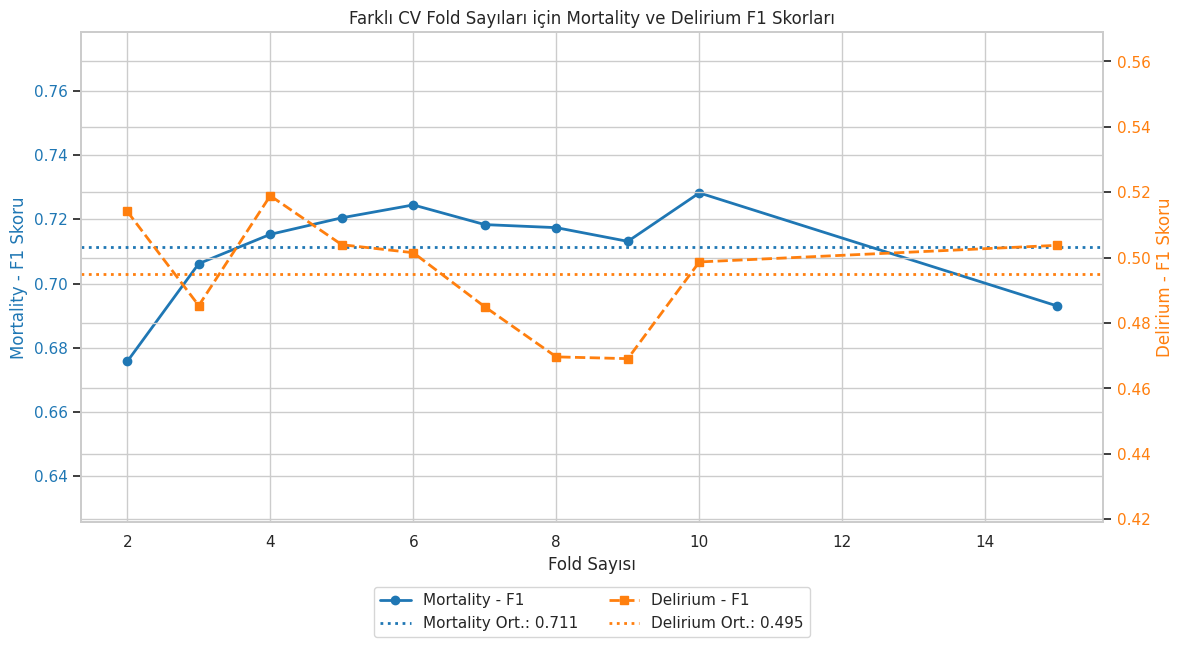

In [ ]:
df7 = df.copy()
X = df7.drop(columns=['mortality', 'delirium_positive', 'subject_id']).values
y_mortality = df7['mortality'].values
y_delirium = df7['delirium_positive'].values

def get_pipeline(sampling_strategy):
    return Pipeline([
        ('smote', BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42)),
        ('scaler', StandardScaler()),
        ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])

f1_scores_mortality = {}
f1_scores_delirium = {}

splits_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15]

for n in splits_list:
    cv = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)

    f1s_mort = []
    f1s_del = []

    for train_idx, val_idx in cv.split(X, y_mortality):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_mortality[train_idx], y_mortality[val_idx]
        pipeline_mortality = get_pipeline('auto')
        pipeline_mortality.fit(X_train, y_train)
        y_pred = pipeline_mortality.predict(X_val)
        f1s_mort.append(f1_score(y_val, y_pred, average='macro'))

    f1_scores_mortality[n] = np.mean(f1s_mort)

    for train_idx, val_idx in cv.split(X, y_delirium):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_delirium[train_idx], y_delirium[val_idx]
        pipeline_delirium = get_pipeline(0.7)
        pipeline_delirium.fit(X_train, y_train)
        y_pred = pipeline_delirium.predict(X_val)
        f1s_del.append(f1_score(y_val, y_pred, average='macro'))

    f1_scores_delirium[n] = np.mean(f1s_del)

print("F1 Scores Mortality:", f1_scores_mortality)
print("F1 Scores Delirium:", f1_scores_delirium)

fig, ax1 = plt.subplots(figsize=(12, 6))

splits_numeric = list(f1_scores_mortality.keys())
mortality_scores = list(f1_scores_mortality.values())
delirium_scores = list(f1_scores_delirium.values())

mean_f1_mortality = np.mean(mortality_scores)
mean_f1_delirium = np.mean(delirium_scores)

color1 = 'tab:blue'
ax1.set_xlabel("Fold Sayısı")
ax1.set_ylabel("Mortality - F1 Skoru", color=color1)
ax1.plot(splits_numeric, mortality_scores, marker='o', linestyle='-', color=color1, linewidth=2, label="Mortality - F1")
ax1.axhline(mean_f1_mortality, color=color1, linestyle=':', linewidth=2, label=f"Mortality Ort.: {mean_f1_mortality:.3f}")
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(min(mortality_scores) - 0.05, max(mortality_scores) + 0.05)

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel("Delirium - F1 Skoru", color=color2)
ax2.plot(splits_numeric, delirium_scores, marker='s', linestyle='--', color=color2, linewidth=2, label="Delirium - F1")
ax2.axhline(mean_f1_delirium, color=color2, linestyle=':', linewidth=2, label=f"Delirium Ort.: {mean_f1_delirium:.3f}")
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(min(delirium_scores) - 0.05, max(delirium_scores) + 0.05)

plt.title("Farklı CV Fold Sayıları için Mortality ve Delirium F1 Skorları")
fig.tight_layout()
plt.grid(True)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)


plt.show()

**Farklı CV Fold Sayıları için Mortality ve Delirium ROC AUC Skorları Grafiği**

ROC AUC Scores Mortality: {2: np.float64(0.765370374868104), 3: np.float64(0.776823483685761), 4: np.float64(0.8006561855346048), 5: np.float64(0.8153231179213858), 6: np.float64(0.8015075538261023), 7: np.float64(0.8251738212689699), 8: np.float64(0.8229610322389826), 9: np.float64(0.8235958701074981), 10: np.float64(0.8188731443994601), 15: np.float64(0.8194365305476415)}
ROC AUC Scores Delirium: {2: np.float64(0.6101425705252919), 3: np.float64(0.5968161143599741), 4: np.float64(0.6445985411283377), 5: np.float64(0.6333365967746323), 6: np.float64(0.5887083903328774), 7: np.float64(0.5907076263240646), 8: np.float64(0.5683961004273504), 9: np.float64(0.6001461988304093), 10: np.float64(0.6042663219133807), 15: np.float64(0.6173949579831931)}


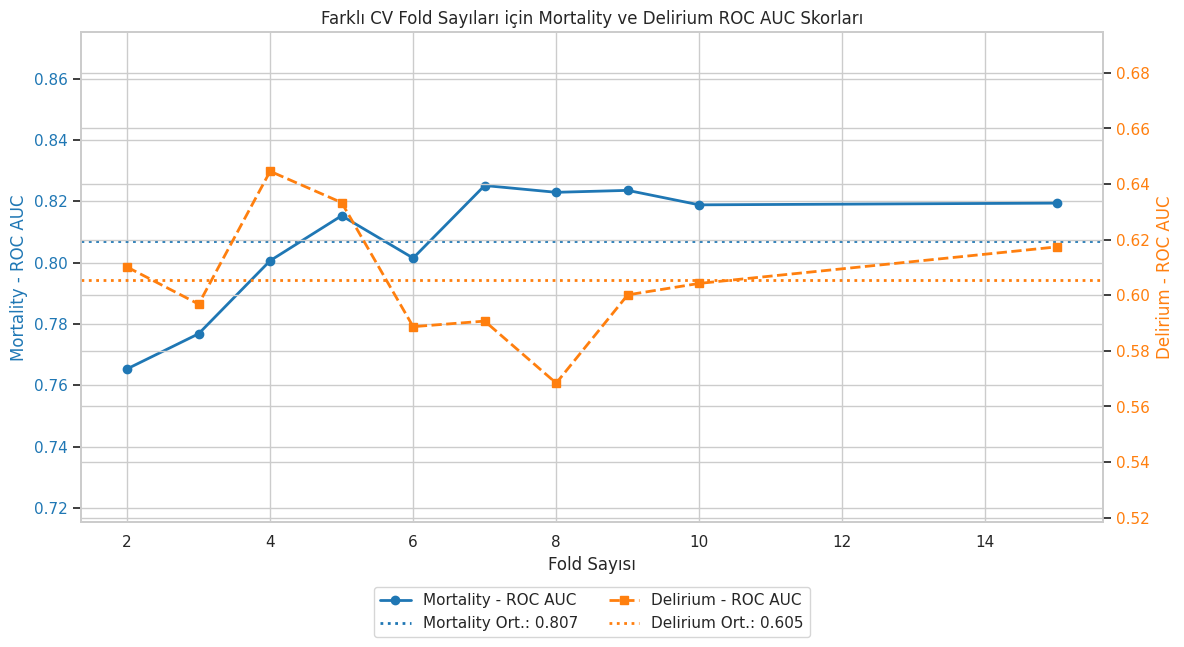

In [ ]:
df8 = df.copy()
X = df8.drop(columns=['mortality', 'delirium_positive', 'subject_id']).values
y_mortality = df8['mortality'].values
y_delirium = df8['delirium_positive'].values

def get_pipeline(sampling_strategy):
    return Pipeline([
        ('smote', BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42)),
        ('scaler', StandardScaler()),
        ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])

roc_auc_scores_mortality = {}
roc_auc_scores_delirium = {}

splits_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15]

for n in splits_list:
    cv = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)

    roc_auc_mort = []
    roc_auc_del = []

    for train_idx, val_idx in cv.split(X, y_mortality):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_mortality[train_idx], y_mortality[val_idx]
        pipeline_mortality = get_pipeline('auto')
        pipeline_mortality.fit(X_train, y_train)
        y_prob = pipeline_mortality.predict_proba(X_val)[:, 1]
        roc_auc_mort.append(roc_auc_score(y_val, y_prob))

    roc_auc_scores_mortality[n] = np.mean(roc_auc_mort)

    for train_idx, val_idx in cv.split(X, y_delirium):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_delirium[train_idx], y_delirium[val_idx]
        pipeline_delirium = get_pipeline(0.7)
        pipeline_delirium.fit(X_train, y_train)
        y_prob = pipeline_delirium.predict_proba(X_val)[:, 1]
        roc_auc_del.append(roc_auc_score(y_val, y_prob))

    roc_auc_scores_delirium[n] = np.mean(roc_auc_del)

print("ROC AUC Scores Mortality:", roc_auc_scores_mortality)
print("ROC AUC Scores Delirium:", roc_auc_scores_delirium)

fig, ax1 = plt.subplots(figsize=(12, 6))

splits_numeric = list(roc_auc_scores_mortality.keys())
mortality_roc_auc = list(roc_auc_scores_mortality.values())
delirium_roc_auc = list(roc_auc_scores_delirium.values())

mean_roc_auc_mortality = np.mean(mortality_roc_auc)
mean_roc_auc_delirium = np.mean(delirium_roc_auc)

color1 = 'tab:blue'
ax1.set_xlabel("Fold Sayısı")
ax1.set_ylabel("Mortality - ROC AUC", color=color1)
ax1.plot(splits_numeric, mortality_roc_auc, marker='o', linestyle='-', color=color1, linewidth=2, label="Mortality - ROC AUC")
ax1.axhline(mean_roc_auc_mortality, color=color1, linestyle=':', linewidth=2, label=f"Mortality Ort.: {mean_roc_auc_mortality:.3f}")
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(min(mortality_roc_auc) - 0.05, max(mortality_roc_auc) + 0.05)

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel("Delirium - ROC AUC", color=color2)
ax2.plot(splits_numeric, delirium_roc_auc, marker='s', linestyle='--', color=color2, linewidth=2, label="Delirium - ROC AUC")
ax2.axhline(mean_roc_auc_delirium, color=color2, linestyle=':', linewidth=2, label=f"Delirium Ort.: {mean_roc_auc_delirium:.3f}")
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(min(delirium_roc_auc) - 0.05, max(delirium_roc_auc) + 0.05)

plt.title("Farklı CV Fold Sayıları için Mortality ve Delirium ROC AUC Skorları")
fig.tight_layout()
plt.grid(True)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)

plt.show()

In [ ]:
def preprocess_data(df):
    X = df.drop(columns=['mortality', 'delirium_positive', 'subject_id']).values
    y_mortality = df['mortality'].values
    y_delirium = df['delirium_positive'].values
    return X, y_mortality, y_delirium


In [ ]:
def evaluate_models(X, y, task_name, model=None, sampling_strategy='auto'):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Eğer model verilmediyse tüm modelleri değerlendir
    if model is None:
        print(f"\n-------- {task_name.upper()} Classification Results (All Models) --------")
        for name, mdl in models.items():
            aucs, reports = [], []
            for train_idx, val_idx in cv.split(X, y):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                pipeline = Pipeline([
                    ('smote', BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42)),
                    ('scaler', StandardScaler()),
                    ('model', mdl)
                ])
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_val)
                y_proba = pipeline.predict_proba(X_val)[:, 1]
                aucs.append(roc_auc_score(y_val, y_proba))
                reports.append(classification_report(y_val, y_pred, output_dict=True))

            print_average_report(name, reports, np.mean(aucs), task_name)
    else:
        # Sadece verilen modeli değerlendir
        name = model.__class__.__name__
        print(f"\n-------- {task_name.upper()} - {name} Classification Results --------")
        aucs, reports = [], []
        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            pipeline = Pipeline([
                ('smote', BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42)),
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_val)
            y_proba = pipeline.predict_proba(X_val)[:, 1]
            aucs.append(roc_auc_score(y_val, y_proba))
            reports.append(classification_report(y_val, y_pred, output_dict=True))

        print_average_report(name, reports, np.mean(aucs), task_name)


In [ ]:
def print_average_report(name, reports, mean_auc, task_name):
    def avg_metric(metric, label):
        return np.mean([r[label][metric] for r in reports if label in r])

    labels = ['0', '1', 'macro avg', 'weighted avg']
    print(f"\nModel: {name}")
    print(f"Mean ROC AUC ({task_name}): {mean_auc:.2f}")

    accuracies = [r['accuracy'] for r in reports if 'accuracy' in r]
    mean_accuracy = np.mean(accuracies)
    print(f"Mean Accuracy ({task_name}): {mean_accuracy:.2f}\n")

    print(f"{'Label':15}{'Precision':>10}{'Recall':>10}{'F1-Score':>10}{'Support':>10}")
    for label in labels:
        precision = avg_metric('precision', label)
        recall = avg_metric('recall', label)
        f1 = avg_metric('f1-score', label)
        support = np.mean([r[label]['support'] for r in reports if label in r])
        print(f"{label:15}{precision:10.2f}{recall:10.2f}{f1:10.2f}{support:10.0f}")


In [ ]:
# --- Model Tanımları ---
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
cat = CatBoostClassifier(verbose=0, random_state=42)

# Ensemble model
voting = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
    voting='soft',
    n_jobs=-1
)

models = {
    "RandomForest": rf,
    "XGBoost": xgb,
    "CatBoost": cat,
    "VotingEnsemble": voting
}


**Ensemble**

Önceki adımlarda ayrı ayrı uyguladığımız BorderlineSMOTE ve StandardScaler
işlemleri bu aşamada bir pipeline yapısı içinde birleştirilmiştir. Sadece tek bir model yerine; Random Forest, XGBoost ve CatBoost olmak üzere üç farklı makine öğrenimi algoritması kullanılmıştır. Bu modellerin çıktıları Voting Classifier ile birleştirilerek topluluk modeli oluşturulmuştur.


In [ ]:
X, y_mortality, y_delirium = preprocess_data(df)

In [ ]:
# --- Ana İşlem Akışı ---
evaluate_models(X, y_mortality, "mortality", sampling_strategy='auto')
evaluate_models(X, y_delirium, "delirium", sampling_strategy='auto')


-------- MORTALITY Classification Results (All Models) --------

Model: RandomForest
Mean ROC AUC (mortality): 0.77
Mean Accuracy (mortality): 0.76

Label           Precision    Recall  F1-Score   Support
0                    0.80      0.86      0.83        79
1                    0.67      0.54      0.59        38
macro avg            0.73      0.70      0.71       117
weighted avg         0.76      0.76      0.75       117

Model: XGBoost
Mean ROC AUC (mortality): 0.82
Mean Accuracy (mortality): 0.76

Label           Precision    Recall  F1-Score   Support
0                    0.82      0.84      0.82        79
1                    0.66      0.60      0.62        38
macro avg            0.74      0.72      0.72       117
weighted avg         0.76      0.76      0.76       117

Model: CatBoost
Mean ROC AUC (mortality): 0.82
Mean Accuracy (mortality): 0.76

Label           Precision    Recall  F1-Score   Support
0                    0.81      0.84      0.83        79
1                

- **stay_id:** Her bir ICU yatışı için sistem tarafından atanan unique id'dir. Ancak çalışmamızda yalnızca tek ICU kalışı olan hastalar yer aldığı için bu değişken analiz açısından anlamlı bir farklılık sunmamaktadır.

- **record_count:** Her hastanın kaç kez ICU'ya yattığını gösteren ve tarafımızdan hesaplanan bir değişkendir. Seçilen kohortta her hastanın yalnızca bir adet ICU yatışı bulunduğundan, bu bilgi sabittir ve modele katkı sağlamamaktadır.

In [ ]:
df = df.drop(columns=['stay_id', 'record_count'])

**Modele geçilmeden önce yapılan istatistiksel testler sonucunda, anlamsız olduğu belirlenen sayısal ve kategorik değişkenler veri setinden çıkarılmıştır.**

In [ ]:
anlamsiz_num_list = ortak_anlamsiz_num['Değişken'].tolist()
anlamsiz_cat_list = anlamsiz_cat_both['Değişken'].tolist()
anlamsiz_deg_listesi = anlamsiz_num_list + anlamsiz_cat_list

anlamsiz_deg_listesi = [deg for deg in anlamsiz_deg_listesi if (deg != 'subject_id' and deg != 'stay_id' )]

df_copy = df.drop(columns=anlamsiz_deg_listesi)


In [ ]:
df_copy.shape

(585, 94)

In [ ]:
X, y_mortality, y_delirium = preprocess_data(df_copy)

In [ ]:
# --- Ana İşlem Akışı ---
evaluate_models(X, y_mortality, "mortality", sampling_strategy='auto')
evaluate_models(X, y_delirium, "delirium", sampling_strategy='auto')


-------- MORTALITY Classification Results (All Models) --------

Model: RandomForest
Mean ROC AUC (mortality): 0.78
Mean Accuracy (mortality): 0.74

Label           Precision    Recall  F1-Score   Support
0                    0.79      0.84      0.81        79
1                    0.61      0.52      0.55        38
macro avg            0.70      0.68      0.68       117
weighted avg         0.73      0.74      0.73       117

Model: XGBoost
Mean ROC AUC (mortality): 0.80
Mean Accuracy (mortality): 0.74

Label           Precision    Recall  F1-Score   Support
0                    0.80      0.82      0.81        79
1                    0.62      0.57      0.58        38
macro avg            0.71      0.69      0.69       117
weighted avg         0.74      0.74      0.73       117

Model: CatBoost
Mean ROC AUC (mortality): 0.82
Mean Accuracy (mortality): 0.76

Label           Precision    Recall  F1-Score   Support
0                    0.82      0.83      0.82        79
1                

In [ ]:
def shap_select_features(X, y, model, top_n=40):
    model.fit(X, y)
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    feature_importance = pd.DataFrame({'feature': X.columns, 'mean_abs_shap': mean_shap})

    # SHAP değerine göre sıralama ve top_n seçim
    feature_importance = feature_importance.sort_values(by='mean_abs_shap', ascending=False)
    selected_features = feature_importance.head(top_n)['feature'].tolist()
    return selected_features

In [ ]:
xgb_model = models['XGBoost']
cat_model = models['CatBoost']

X_full = df.drop(columns=['mortality', 'delirium_positive', 'subject_id'])

# SHAP feature selection
sel_mort_xgb = shap_select_features(X_full, y_mortality, xgb_model, top_n=40)
sel_del_xgb = shap_select_features(X_full, y_delirium, xgb_model, top_n=40)

sel_mort_cat = shap_select_features(X_full, y_mortality, cat_model, top_n=40)
sel_del_cat = shap_select_features(X_full, y_delirium, cat_model, top_n=40)

# INTERSECTION
sel_mort = list(set(sel_mort_xgb) & set(sel_mort_cat))
sel_del = list(set(sel_del_xgb) & set(sel_del_cat))

# Ortak özellikler
print("\n--- MORTALITY için ortak SHAP özellikleri (XGBoost ∩ CatBoost) ---")
print(sel_mort)
print(f"Toplam {len(sel_mort)} özellik")

print("\n--- DELIRIUM için ortak SHAP özellikleri (XGBoost ∩ CatBoost) ---")
print(sel_del)
print(f"Toplam {len(sel_del)} özellik")

X_mort = df[sel_mort].values
X_del = df[sel_del].values

# --- XGBoost ile değerlendirme ---
print("\n================== XGBOOST SONUÇLARI ==================")
xgb_model = models['XGBoost']
evaluate_models(X_mort, y_mortality, 'mortality - XGBoost (intersection)', model=xgb_model)
evaluate_models(X_del, y_delirium, 'delirium - XGBoost (intersection)', model=xgb_model)

# --- CatBoost ile değerlendirme ---
print("\n================== CATBOOST SONUÇLARI ==================")
cat_model = models['CatBoost']
evaluate_models(X_mort, y_mortality, 'mortality - CatBoost (intersection)', model=cat_model)
evaluate_models(X_del, y_delirium, 'delirium - CatBoost (intersection)', model=cat_model)

# --- VotingEnsemble ile değerlendirme ---
print("\n================== VOTING ENSEMBLE SONUÇLARI ==================")
voting_model = models['VotingEnsemble']
evaluate_models(X_mort, y_mortality, 'mortality - VotingEnsemble (intersection)', model=voting_model)
evaluate_models(X_del, y_delirium, 'delirium - VotingEnsemble (intersection)', model=voting_model)


100%|===================| 583/585 [00:44<00:00]       


--- MORTALITY için ortak SHAP özellikleri (XGBoost ∩ CatBoost) ---
['liver_failure', 'sapsii', 'HeartRate_max', 'SpO2_min', 'HeartRate_avg', 'aPTT_min', 'age', 'aPTT_max', 'gcs', 'AnionGap_median', 'PH_avg', 'PaO2_median', 'charlson_comorbidity_index', 'DiastolicBP_median', 'PCO2_avg', 'aPTT_avg', 'ami', 'LacticAcid_avg', 'SpO2_avg', 'Magnesium_avg', 'PaO2_max', 'icu_los', 'Hemoglobin_median']
Toplam 23 özellik

--- DELIRIUM için ortak SHAP özellikleri (XGBoost ∩ CatBoost) ---
['SystolicBP_median', 'TotalCalcium_max', 'DiastolicBP_max', 'sapsii', 'Phosphate_avg', 'SedationScore_min', 'SystolicBP_max', 'age', 'aPTT_max', 'gcs', 'SedationScore_avg', 'DiastolicBP_avg', 'TotalCalcium_avg', 'Phosphate_min', 'PH_min', 'charlson_comorbidity_index', 'HeartRate_min', 'TotalCalcium_min', 'AnionGap_avg', 'Phosphate_max', 'Platelets_min', 'PCO2_max', 'PaO2_min', 'copd']
Toplam 24 özellik

================== XGBOOST SONUÇLARI ==================

-------- MORTALITY - XGBOOST (INTERSECTION) - XGBCla

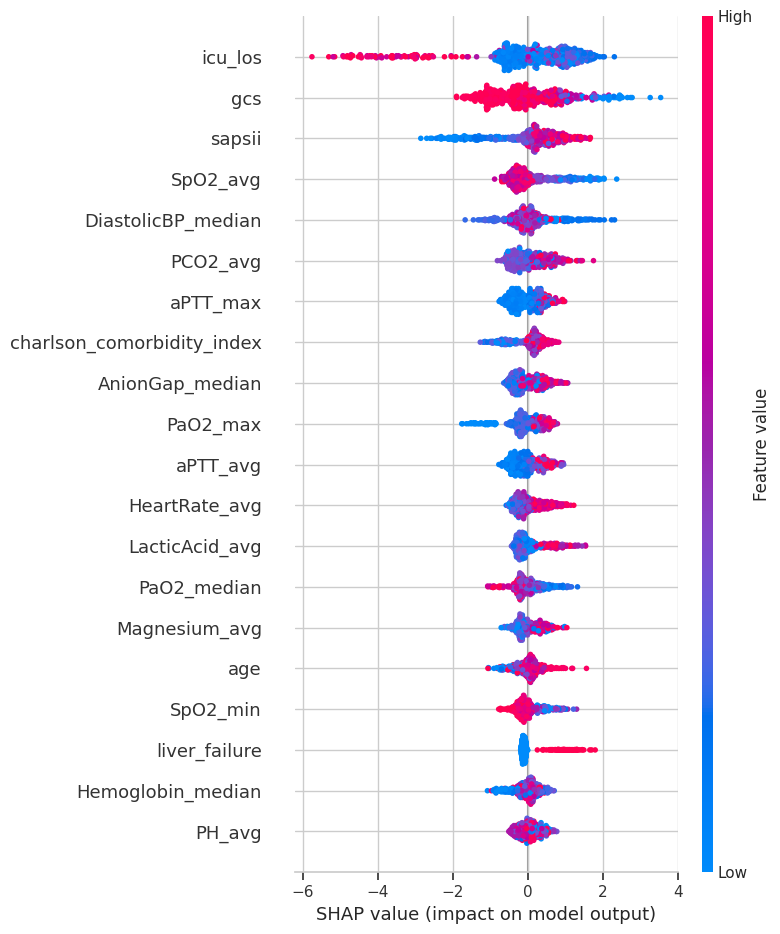

In [ ]:
# Mortality için XGBoost
xgb_model.fit(X_full[sel_mort], y_mortality)  # modeli eğit
explainer_xgb_mort = shap.Explainer(xgb_model, X_full[sel_mort])
shap_values_xgb_mort = explainer_xgb_mort(X_full[sel_mort])

plt.title("Mortality - XGBoost SHAP Summary Plot (Ortak Özellikler)")
shap.summary_plot(shap_values_xgb_mort.values, X_full[sel_mort], feature_names=sel_mort, show=True)


 98%|===================| 575/585 [00:48<00:00]       

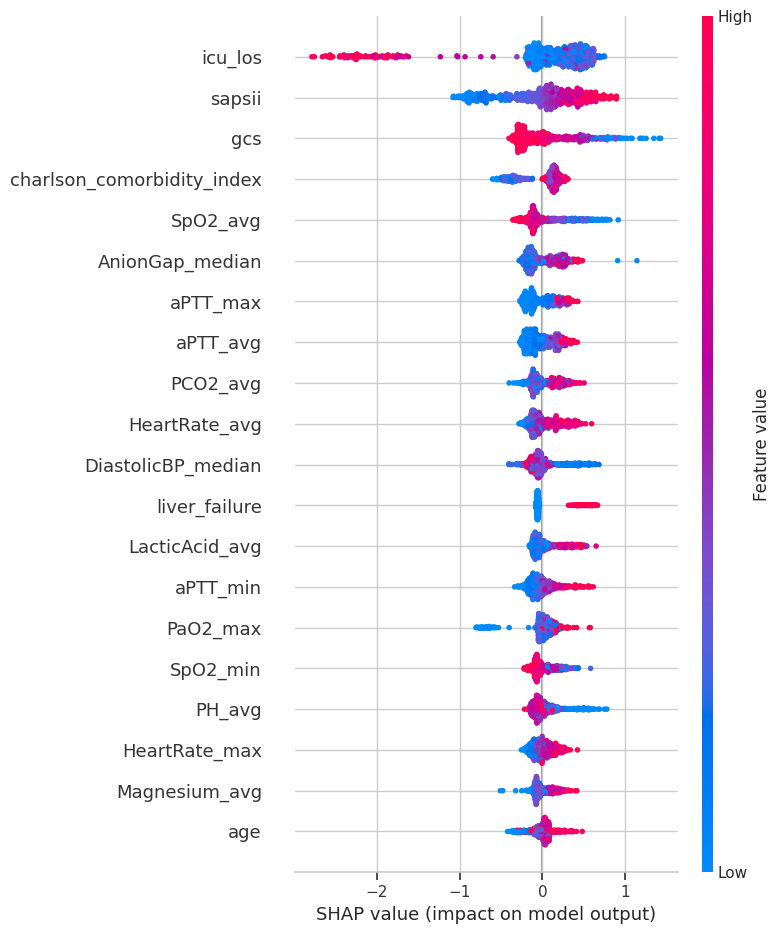

In [ ]:
cat_model.fit(X_full[sel_mort], y_mortality)
explainer_cat_mort = shap.Explainer(cat_model, X_full[sel_mort])
shap_values_cat_mort = explainer_cat_mort(X_full[sel_mort])

plt.title("Mortality - CatBoost SHAP Summary Plot (Ortak Özellikler)")
shap.summary_plot(shap_values_cat_mort.values, X_full[sel_mort], feature_names=sel_mort, show=True)


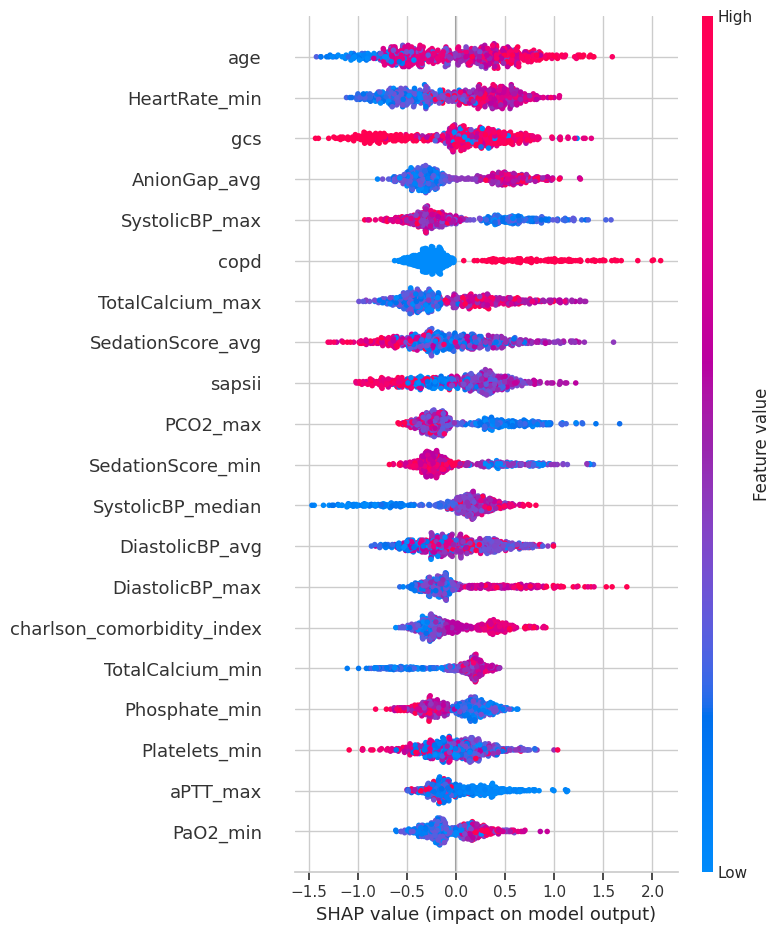

In [ ]:
# XGBoost
xgb_model.fit(X_full[sel_del], y_delirium)
explainer_xgb_del = shap.Explainer(xgb_model, X_full[sel_del])
shap_values_xgb_del = explainer_xgb_del(X_full[sel_del])

plt.title("Delirium - XGBoost SHAP Summary Plot (Ortak Özellikler)")
shap.summary_plot(shap_values_xgb_del.values, X_full[sel_del], feature_names=sel_del, show=True)


 98%|===================| 574/585 [00:50<00:00]       

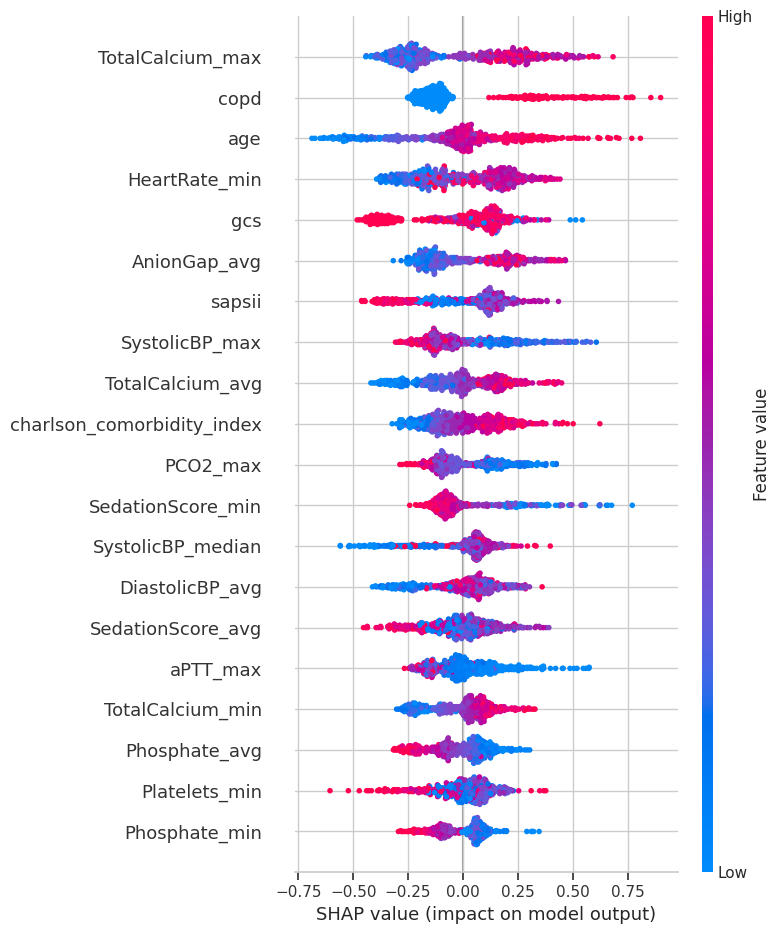

In [ ]:
# CatBoost
cat_model.fit(X_full[sel_del], y_delirium)
explainer_cat_del = shap.Explainer(cat_model, X_full[sel_del])
shap_values_cat_del = explainer_cat_del(X_full[sel_del])

plt.title("Delirium - CatBoost SHAP Summary Plot (Ortak Özellikler)")
shap.summary_plot(shap_values_cat_del.values, X_full[sel_del], feature_names=sel_del, show=True)


**İstatistiksel Testler Sonucu Anlamsız Özelliklerin Çıkarılması ve SHAP Tabanlı Özellik Seçimi ile Voting Model Oluşturulması**

Çalışmada, ilk olarak istatistiksel testler uygulanarak hedef değişkenle anlamlı ilişkisi bulunmayan anlamsız özellikler veri setinden çıkarılmıştır. Ardından, XGBoost ve CatBoost modelleri için SHAP (SHapley Additive exPlanations) yöntemi kullanılarak her model için en önemli 40 özellik belirlenmiştir. Bu iki modelin seçtiği özelliklerin kesişimi alınarak, hem XGBoost hem de CatBoost açısından önemli kabul edilen ortak özellik kümesi elde edilmiştir. Elde edilen bu özellik kümesi kullanılarak, XGBoost, CatBoost ve Random Forest modellerinden oluşan bir Voting Ensemble Model oluşturulmuş ve en yüksek başarıyı sağlayan model kaydedilmiştir.

In [ ]:
# XGBoost ve CatBoost modellerini al
xgb_model = models['XGBoost']
cat_model = models['CatBoost']

X_full = df_copy.drop(columns=['mortality', 'delirium_positive', 'subject_id'])

# SHAP Feature Selection
sel_mort_xgb = shap_select_features(X_full, y_mortality, xgb_model, top_n=40)
sel_del_xgb = shap_select_features(X_full, y_delirium, xgb_model, top_n=40)

sel_mort_cat = shap_select_features(X_full, y_mortality, cat_model, top_n=40)
sel_del_cat = shap_select_features(X_full, y_delirium, cat_model, top_n=40)

# ORTAK ÖZELLİKLER (XGBoost ∩ CatBoost)
sel_mort = list(set(sel_mort_xgb) & set(sel_mort_cat))
sel_del = list(set(sel_del_xgb) & set(sel_del_cat))

print("\n--- MORTALITY için ortak SHAP özellikleri ---")
print(sel_mort, f"Toplam {len(sel_mort)} özellik")

print("\n--- DELIRIUM için ortak SHAP özellikleri ---")
print(sel_del, f"Toplam {len(sel_del)} özellik")

# Özellikleri seç
X_mort = df[sel_mort].values
y_mort = df['mortality'].values

X_del = df[sel_del].values
y_del = df['delirium_positive'].values

# === RANDOM FOREST TANIMLARI ve EĞİTİM ===
rf_model_mort = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model_del = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model_mort.fit(X_mort, y_mort)
rf_model_del.fit(X_del, y_del)

# === VOTING ENSEMBLE YENİDEN TANIMLA ===
voting_model_mort = VotingClassifier(
    estimators=[('rf', rf_model_mort), ('xgb', xgb_model), ('cat', cat_model)],
    voting='soft',
    n_jobs=-1
)
voting_model_del = VotingClassifier(
    estimators=[('rf', rf_model_del), ('xgb', xgb_model), ('cat', cat_model)],
    voting='soft',
    n_jobs=-1
)

# === EVALUATE ===

# XGBoost
print("\n================== XGBOOST SONUÇLARI ==================")
evaluate_models(X_mort, y_mort, 'mortality - XGBoost (intersection)', model=xgb_model)
evaluate_models(X_del, y_del, 'delirium - XGBoost (intersection)', model=xgb_model)

# CatBoost
print("\n================== CATBOOST SONUÇLARI ==================")
evaluate_models(X_mort, y_mort, 'mortality - CatBoost (intersection)', model=cat_model)
evaluate_models(X_del, y_del, 'delirium - CatBoost (intersection)', model=cat_model)

# RandomForest
print("\n================== RANDOM FOREST SONUÇLARI ==================")
evaluate_models(X_mort, y_mort, 'mortality - RandomForest (intersection)', model=rf_model_mort)
evaluate_models(X_del, y_del, 'delirium - RandomForest (intersection)', model=rf_model_del)

# VotingEnsemble
print("\n================== VOTING ENSEMBLE SONUÇLARI ==================")
evaluate_models(X_mort, y_mort, 'mortality - VotingEnsemble (intersection)', model=voting_model_mort)
evaluate_models(X_del, y_del, 'delirium - VotingEnsemble (intersection)', model=voting_model_del)


 98%|===================| 572/585 [00:35<00:00]       


--- MORTALITY için ortak SHAP özellikleri ---
['AnionGap_median', 'HeartRate_avg', 'SedationScore_avg', 'SystolicBP_avg', 'sapsii', 'SpO2_min', 'HeartRate_max', 'aPTT_min', 'LacticAcid_max', 'DiastolicBP_min', 'aPTT_avg', 'age', 'aPTT_median', 'PH_avg', 'AnionGap_min', 'PH_max', 'icu_los', 'aPTT_max', 'charlson_comorbidity_index', 'ami', 'Potassium_avg', 'liver_failure', 'PH_min', 'PH_median', 'gcs', 'SpO2_avg'] Toplam 26 özellik

--- DELIRIUM için ortak SHAP özellikleri ---
['TotalCalcium_min', 'HeartRate_avg', 'HeartRate_median', 'SedationScore_avg', 'Phosphate_min', 'Magnesium_min', 'sapsii', 'TotalCalcium_max', 'DiastolicBP_min', 'Platelets_min', 'ProthrombinTime_PT_max', 'TotalCalcium_avg', 'age', 'PH_avg', 'Bicarbonate_median', 'SystolicBP_median', 'aPTT_max', 'HeartRate_min', 'icu_los', 'Glucose_max', 'charlson_comorbidity_index', 'Potassium_min', 'copd', 'Bicarbonate_avg', 'Phosphate_avg', 'ProthrombinTime_PT_min', 'PH_min', 'AnionGap_avg', 'gcs', 'SpO2_avg'] Toplam 30 özellik

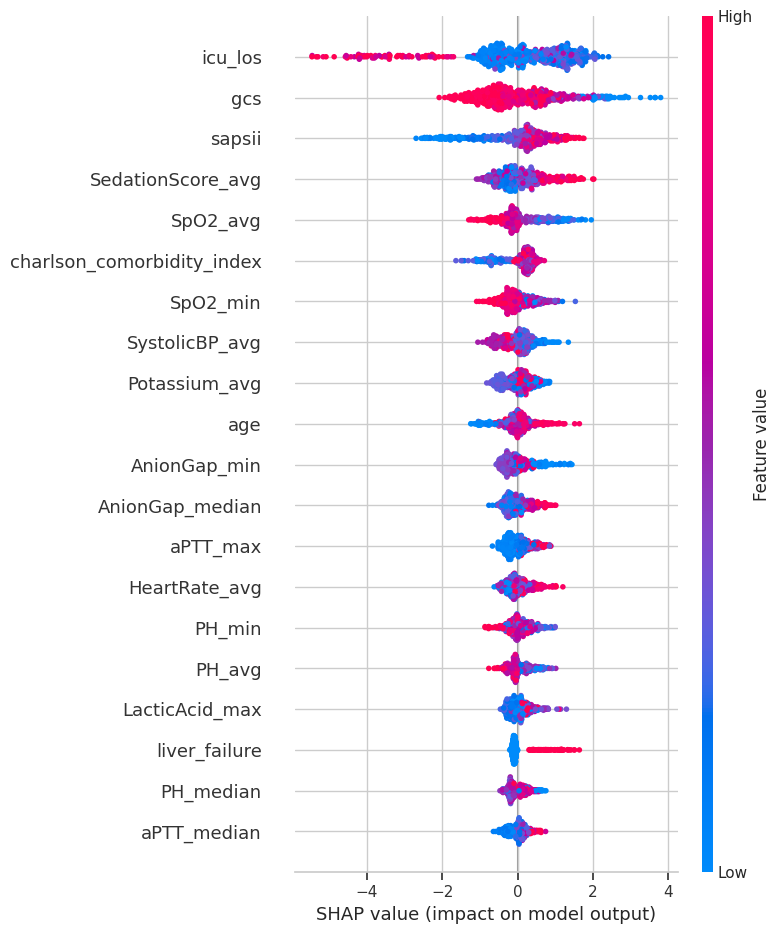

In [ ]:
# Mortality için XGBoost
xgb_model.fit(X_full[sel_mort], y_mortality)  # modeli eğit
explainer_xgb_mort = shap.Explainer(xgb_model, X_full[sel_mort])
shap_values_xgb_mort = explainer_xgb_mort(X_full[sel_mort])

plt.title("Mortality - XGBoost SHAP Summary Plot (Ortak Özellikler)")
shap.summary_plot(shap_values_xgb_mort.values, X_full[sel_mort], feature_names=sel_mort, show=True)


 97%|=================== | 569/585 [00:36<00:01]       

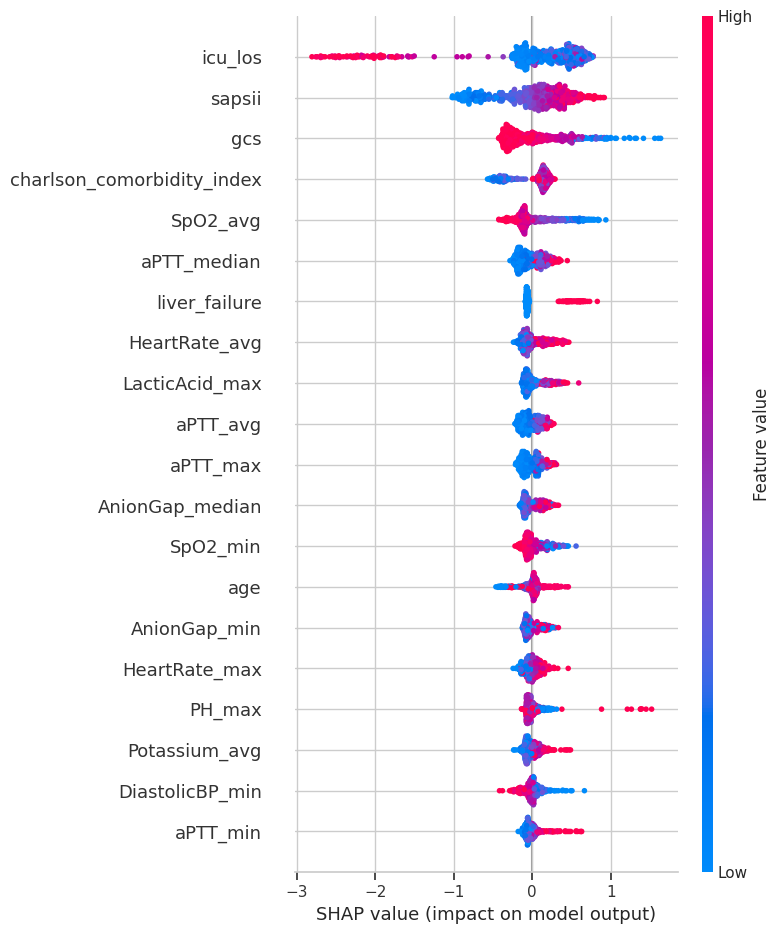

In [ ]:
cat_model.fit(X_full[sel_mort], y_mortality)
explainer_cat_mort = shap.Explainer(cat_model, X_full[sel_mort])
shap_values_cat_mort = explainer_cat_mort(X_full[sel_mort])

plt.title("Mortality - CatBoost SHAP Summary Plot (Ortak Özellikler)")
shap.summary_plot(shap_values_cat_mort.values, X_full[sel_mort], feature_names=sel_mort, show=True)


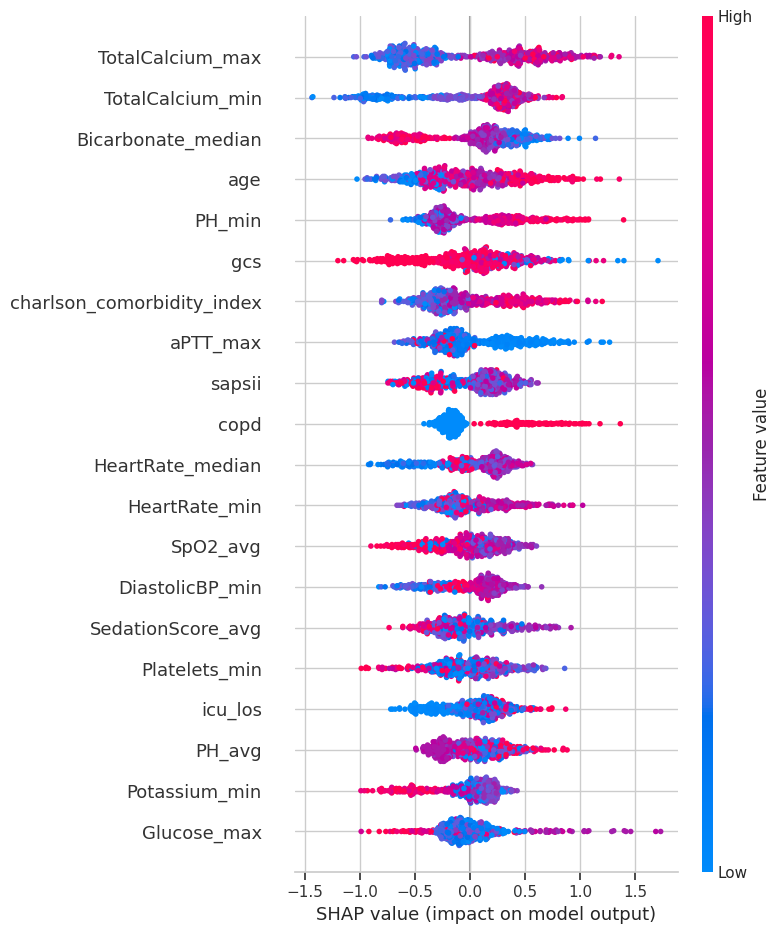

In [ ]:
# XGBoost
xgb_model.fit(X_full[sel_del], y_delirium)
explainer_xgb_del = shap.Explainer(xgb_model, X_full[sel_del])
shap_values_xgb_del = explainer_xgb_del(X_full[sel_del])

plt.title("Delirium - XGBoost SHAP Summary Plot (Ortak Özellikler)")
shap.summary_plot(shap_values_xgb_del.values, X_full[sel_del], feature_names=sel_del, show=True)


 99%|===================| 579/585 [00:37<00:00]       

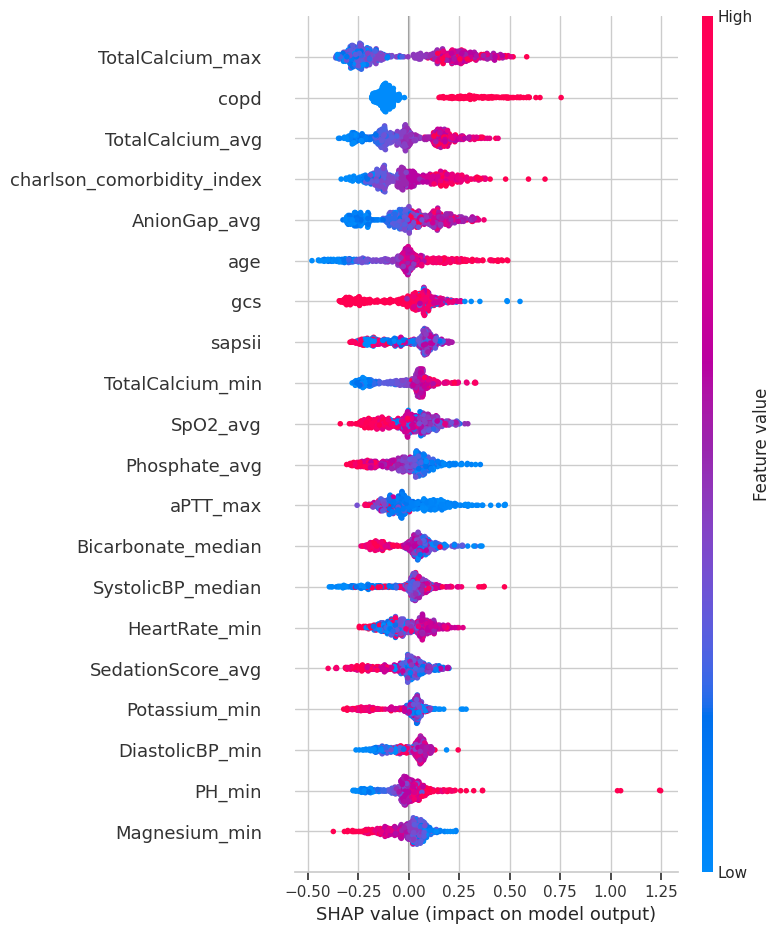

In [ ]:
# CatBoost
cat_model.fit(X_full[sel_del], y_delirium)
explainer_cat_del = shap.Explainer(cat_model, X_full[sel_del])
shap_values_cat_del = explainer_cat_del(X_full[sel_del])

plt.title("Delirium - CatBoost SHAP Summary Plot (Ortak Özellikler)")
shap.summary_plot(shap_values_cat_del.values, X_full[sel_del], feature_names=sel_del, show=True)


**İstatistiksel Testler Sonucu Anlamsız Özelliklerin Çıkarılması ve SHAP Tabanlı Özellik Seçimi ile Voting Model Oluşturulması**

Çalışmada, ilk olarak istatistiksel testler uygulanarak hedef değişkenle anlamlı ilişkisi bulunmayan anlamsız özellikler veri setinden çıkarılmıştır. Ardından, XGBoost ve CatBoost modelleri için SHAP (SHapley Additive exPlanations) yöntemi kullanılarak her model için en önemli 40 özellik belirlenmiştir. Bu iki modelin seçtiği özelliklerin kesişimi alınarak, hem XGBoost hem de CatBoost açısından önemli kabul edilen ortak özellik kümesi elde edilmiştir.

Elde edilen bu özellik kümesiyle, XGBoost, CatBoost ve Random Forest modellerinden oluşan bir Voting Ensemble Model oluşturulmuştur. Modelin eğitimi öncesinde, veri seti %80 eğitim ve %20 test olacak şekilde ikiye ayrılmıştır. Model yalnızca %80’lik eğitim verisi kullanılarak eğitilmiş, %20’lik test verisi ise daha sonra arayüz üzerinde gerçek zamanlı performans değerlendirmesi için ayrılmıştır. Eğitim tamamlandıktan sonra en yüksek başarıyı sağlayan voting model kaydedilmiştir.

In [ ]:
import json
from google.colab import files

# === ANLAMSIZ DEĞİŞKENLERİ KALDIR ===
anlamsiz_num_list = ortak_anlamsiz_num['Değişken'].tolist()
anlamsiz_cat_list = anlamsiz_cat_both['Değişken'].tolist()
anlamsiz_deg_listesi = anlamsiz_num_list + anlamsiz_cat_list
anlamsiz_deg_listesi = [deg for deg in anlamsiz_deg_listesi if deg not in ['subject_id', 'stay_id']]
df_copy = df.drop(columns=anlamsiz_deg_listesi)

# === STRATIFY & TRAIN/TEST SPLIT ===
df_copy["strata"] = df_copy["mortality"].astype(str) + "_" + df_copy["delirium_positive"].astype(str)
train_df, test_df = train_test_split(df_copy, test_size=0.2, stratify=df_copy["strata"], random_state=42)
train_df.drop(columns=["strata"], inplace=True)
test_df.drop(columns=["strata"], inplace=True)

# === TEST VERİYİ KAYDET ===
test_df.to_csv("test.csv", index=False)
files.download("test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# === ETİKET VE ÖZELLİK AYIRIMI ===
X_full = train_df.drop(columns=['mortality', 'delirium_positive', 'subject_id'])
y_mortality = train_df['mortality']
y_delirium = train_df['delirium_positive']

# === SHAP İLE ÖZELLİK SEÇİMİ ===
xgb_model = models['XGBoost']
cat_model = models['CatBoost']

sel_mort_xgb = shap_select_features(X_full, y_mortality, xgb_model, top_n=40)
sel_del_xgb = shap_select_features(X_full, y_delirium, xgb_model, top_n=40)
sel_mort_cat = shap_select_features(X_full, y_mortality, cat_model, top_n=40)
sel_del_cat = shap_select_features(X_full, y_delirium, cat_model, top_n=40)

sel_mort = list(set(sel_mort_xgb) & set(sel_mort_cat))
sel_del = list(set(sel_del_xgb) & set(sel_del_cat))

print("\n--- MORTALITY için ortak SHAP özellikleri ---")
print(sel_mort, f"Toplam {len(sel_mort)} özellik")
print("\n--- DELIRIUM için ortak SHAP özellikleri ---")
print(sel_del, f"Toplam {len(sel_del)} özellik")

# === SHAP İLE SEÇİLEN ÖZELLİKLERE GÖRE VERİYİ AYIR ===
X_train_mort = train_df[sel_mort].values
y_train_mort = y_mortality.values
X_test_mort = test_df[sel_mort].values
y_test_mort = test_df["mortality"].values

X_train_del = train_df[sel_del].values
y_train_del = y_delirium.values
X_test_del = test_df[sel_del].values
y_test_del = test_df["delirium_positive"].values

# === MORTALITY İÇİN YENİDEN MODEL EĞİT ===
rf_model_mort = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb_model_mort = XGBClassifier(random_state=42, n_jobs=-1, verbosity=0)
cat_model_mort = CatBoostClassifier(verbose=0, random_state=42)

rf_model_mort.fit(X_train_mort, y_train_mort)
xgb_model_mort.fit(X_train_mort, y_train_mort)
cat_model_mort.fit(X_train_mort, y_train_mort)

voting_model_mort = VotingClassifier(
    estimators=[
        ('rf', rf_model_mort),
        ('xgb', xgb_model_mort),
        ('cat', cat_model_mort)
    ],
    voting='soft',
    n_jobs=-1
)

# === DELIRIUM İÇİN YENİDEN MODEL EĞİT ===
rf_model_del = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb_model_del = XGBClassifier(random_state=42, n_jobs=-1, verbosity=0)
cat_model_del = CatBoostClassifier(verbose=0, random_state=42)

rf_model_del.fit(X_train_del, y_train_del)
xgb_model_del.fit(X_train_del, y_train_del)
cat_model_del.fit(X_train_del, y_train_del)

voting_model_del = VotingClassifier(
    estimators=[
        ('rf', rf_model_del),
        ('xgb', xgb_model_del),
        ('cat', cat_model_del)
    ],
    voting='soft',
    n_jobs=-1
)


 99%|===================| 465/468 [00:30<00:00]       


--- MORTALITY için ortak SHAP özellikleri ---
['AnionGap_median', 'LactateDehydrogenase_avg', 'SedationScore_avg', 'sapsii', 'SpO2_min', 'aPTT_min', 'HeartRate_max', 'LacticAcid_max', 'DiastolicBP_min', 'aPTT_avg', 'Magnesium_avg', 'age', 'aPTT_median', 'PH_avg', 'AnionGap_min', 'PH_max', 'icu_los', 'aPTT_max', 'charlson_comorbidity_index', 'ami', 'SpO2_median', 'AST_min', 'LacticAcid_min', 'liver_failure', 'AnionGap_avg', 'gcs', 'SpO2_avg'] Toplam 27 özellik

--- DELIRIUM için ortak SHAP özellikleri ---
['HeartRate_median', 'Platelets_median', 'SedationScore_avg', 'Phosphate_min', 'sapsii', 'TotalCalcium_max', 'LacticAcid_max', 'DiastolicBP_min', 'Platelets_min', 'TotalCalcium_avg', 'age', 'PH_avg', 'Bicarbonate_median', 'SystolicBP_median', 'PH_median', 'aPTT_max', 'HeartRate_min', 'Potassium_max', 'charlson_comorbidity_index', 'Potassium_min', 'Bicarbonate_avg', 'ProthrombinTime_PT_min', 'Phosphate_avg', 'PH_min', 'BUN_median', 'TotalCalcium_min', 'gcs', 'SpO2_avg'] Toplam 28 özell

In [ ]:
# === SHAP ÖZELLİKLERİ KAYIT ===
selected_features = {"mortality": sel_mort, "delirium": sel_del}
with open("selected_features.json", "w") as f:
    json.dump(selected_features, f, indent=4)
files.download("selected_features.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def train_model(X, y, model, sampling_strategy='auto'):
    pipeline = Pipeline([
        ('smote', BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42)),
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X, y)
    return pipeline

mortality_pipeline = train_model(X_train_mort, y_train_mort, voting_model_mort)
delirium_pipeline = train_model(X_train_del, y_train_del, voting_model_del)


In [ ]:
# === DEĞERLENDİRME FONKSİYONU ===
def evaluate_test_model(name, model, X_test, y_test):
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        print(f"Test ROC AUC: {auc:.3f}")
    else:
        print("Model does not support predict_proba, skipping AUC.")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [ ]:
# === TÜM MODELLERİ TEST ET ===
print("\n====== MORTALITY MODELLERİ TEST SONUÇLARI ======")
evaluate_test_model("Random Forest (mortality)", rf_model_mort, X_test_mort, y_test_mort)
evaluate_test_model("XGBoost (mortality)", xgb_model_mort, X_test_mort, y_test_mort)
evaluate_test_model("CatBoost (mortality)", cat_model_mort, X_test_mort, y_test_mort)
evaluate_test_model("Voting Ensemble (mortality)", mortality_pipeline, X_test_mort, y_test_mort)

print("\n====== DELIRIUM MODELLERİ TEST SONUÇLARI ======")
evaluate_test_model("Random Forest (delirium)", rf_model_del, X_test_del, y_test_del)
evaluate_test_model("XGBoost (delirium)", xgb_model_del, X_test_del, y_test_del)
evaluate_test_model("CatBoost (delirium)", cat_model_del, X_test_del, y_test_del)
evaluate_test_model("Voting Ensemble (delirium)", delirium_pipeline, X_test_del, y_test_del)


====== MORTALITY MODELLERİ TEST SONUÇLARI ======

--- Random Forest (mortality) ---
Test ROC AUC: 0.805
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82        79
           1       0.67      0.37      0.47        38

    accuracy                           0.74       117
   macro avg       0.71      0.64      0.65       117
weighted avg       0.72      0.74      0.71       117


--- XGBoost (mortality) ---
Test ROC AUC: 0.806
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82        79
           1       0.64      0.42      0.51        38

    accuracy                           0.74       117
   macro avg       0.70      0.65      0.66       117
weighted avg       0.72      0.74      0.72       117


--- CatBoost (mortality) ---
Test ROC AUC: 0.856
Classification Report:
              precision    recall  f1-score   support

           0      

In [ ]:
# === MODELLERİ KAYDET ===
import joblib
models_to_save = {
    'mortality': mortality_pipeline,
    'delirium': delirium_pipeline
}
joblib.dump(models_to_save, "models.pkl")
files.download("models.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>